## Instructions d'installation
```
python3 -m venv /path/to/daphne_venv/
/path/to/daphne_venv/bin/activate 
python -m pip install numpy imageio scikit-image vtk nibabel ipykernel
python -m ipykernel install --user --name=daphne


```


# Algorithmes de reconstruction itérative en imagerie TEP
# Analyse qualitative & Quantitative

### Introduction

Ce notebook montre comment effectuer une reconstruction itérative en utilisant la librairie DAPHNE, librairie didactique compagnon de l'ouvrage:
*Panetta D, Camarlinghi N. 3D Image Reconstruction for CT and PET : A Practical Guide with Python. CRC Press; 2020. https://www.taylorfrancis.com/books/9780429270239*

Il servira de base à un compte rendu dans lequel vous montrerez votre bonne compréhension du fonctionnement de la librairie.

DAPHNE (Didactic tomogrAPHic recoNstruction framEwork) implémente de nombreux outils de haut niveau permettant d'étudier les propriétés des principaux algorithmes de reconstruction CT et TEP.

Nous nous consacrons à la reconstruction itérative en TEP. Le notebook couvre les points suivants : 

1. Import des paquets python
2. Définition de la géométrie du problème
3. Chargement du fantôme 3D (et affichage)
4. Projection (obtention du sinogramme) avec la méthode de Siddon
5. Configuration et reconstruction itérative. Les algorithmes de reconstruction implémentés dans DAPHNE sont ART, SIRT, MLEM, OSEM. 
6. Affichage de l'image reconstruite

### Instructions pour le TP
Le but du TP est d'analyser qualitativement et quantitativement les facteurs principaux influant la qualité de la reconstruction en imagerie TEP: 
* **intensité** et **nature** du bruit (Poissonnien dans les détecteurs, Gaussien dans l'image)
* **nombre d'itérations de la méthode de reconstruction**
* algorithme de reconstruction (**MLEM**, OSEM, **ART**, etc.)

mais aussi...
* nombre d'évènements (pour cette simulation, le nombre de projections)
* pitch entre couronne de détecteurs
* nombre de couronnes
* ...

On s'efforcera de faire une analyse à la fois quantitative et qualitative **commentée** rendant compte d'une bonne compréhension du fonctionnement global de la librairie. Les éléments en gras indiquent les analyses prioritaires.  En particulier, on jugera des performances relatives des algorithmes itératifs en fonction du niveau de bruit (niveau de radioactivité / nombre de désintégrations) et du nombre d'itérations.

# Imports

In [174]:
import sys
import numpy as np
from Misc.Utils import Unpickle,ReadImage
from Geometry.ExperimentalSetupPET import ExperimentalSetupPET
import matplotlib.pyplot as plt
from Algorithms.ProjectionDataGenerator import ProjectionDataGenerator 
from Algorithms.ART import ART
from Algorithms.SIRT import SIRT
from Algorithms.MLEM import MLEM
from Algorithms.OSEM import OSEM
from Algorithms.FBP import FBP
from Misc.DataTypes import voxel_dtype
import nibabel as nib
# taille par défaut des figures
plt.rcParams['figure.figsize'] = [10, 10] 
# si les images sont trop grandes ou trop petites, jouer avec ce nombre.
%matplotlib inline

# Constantes

In [175]:
ALL_ALGOS = ["MLEM", "ART", "SIRT", "OSEM"]
bestAlgo = "OSEM"

# Fonctions

###  Création de la géométrie du système
Nous définissons un détecteur TEP et un champ de vue d'acquisition (target region, TR). Cette information sera stockée dans la classe ExperimentalSetupPET.

Nous utilisons un détecteur TEP cylindrique fait de 400 pixels par couronne * 4 couronnes.
Les paramètres principaux pour établir la géométrie du système sont : 

* radius_mm (scalar,float): valeur définissant le rayon du scanner en mm
* pixels_per_slice_nb (scalar,int): nombre de détecteurs par couronne
* detector_slice_nb (scalar,int): nombre de couronnes de détecteur
* slice_pitch_mm (scalar,float): distance entre deux couronnes en mm
* image_matrix_size_mm (3-vecteur long np.array, float): np.array définissant la taille du TR en mm selon x,y et z
* voxel_size_mm  (3-vecteur long np.array, float): np.array définissant la taille en mm de chaque voxel. **Note**: le nombre total de voxels dans chaque direction est un paramètre dérivé de ces deux dernières valeurs
* h_fan_size (scalar,int): définit le nombre de détecteurs dont un détecteur peut accepter les évènements. Plus ce nombre est élevé, plus il y aura de projections. Chaque pixel est en correspondance avec les $(2*h\_fan\_size+1)\cdot detector\_slice\_nb$ en face de lui. La figure ci-dessous illustre cette situation: 

![PET_detector_fan.png![image.png](attachment:image.png)](attachment:image.png)

Une fois la géométrie définie et configurée, on fait un appel à la méthode Update() pour appliquer ces paramètres et calculer les paramètres dérivés. Tous ces paramètres peuvent ensuite être affichés par la méthode GetInfo(). 

**Note**: DAPHNE est une bibliothèque éducative (non optimisée), et on aura intérêt à garder un paramètre ```number of projections```  $< 5\cdot10^5$ pour éviter des temps de calculs excessifs.

In [176]:
def get_experimental_setup(
    radius_mm=250, 
    pixel_size=np.array([1,1,10]), 
    pixels_per_slice_nb=150 , 
    detector_slice_nb=6, 
    slice_pitch_mm=35,
    image_matrix_size_mm = np.array([264,264,90]),
    voxel_size_mm = np.array([3,3,30]),
    h_fan_size = 50,
    detector_name="mon premier détecteur TEP"
    ):
    # create an empty PET experimental setup
    my_experimental_setup = ExperimentalSetupPET()
    # radius of the cylindrical PET
    my_experimental_setup.radius_mm = radius_mm
    # size of the pixels (visualization purpose only)
    my_experimental_setup.pixel_size = pixel_size
    # number of pixels in the cylindrical geom
    my_experimental_setup.pixels_per_slice_nb = pixels_per_slice_nb 
    # number of detector's slice
    my_experimental_setup.detector_slice_nb = detector_slice_nb
    # pitch of the detector slices 
    my_experimental_setup.slice_pitch_mm = slice_pitch_mm
    # fov size in mm 
    my_experimental_setup.image_matrix_size_mm = image_matrix_size_mm
    # voxel size in mm
    my_experimental_setup.voxel_size_mm = voxel_size_mm
    # h size of for the coincidences
    my_experimental_setup.h_fan_size = h_fan_size 
    # (optional) give a name to the experimental setup 
    my_experimental_setup.detector_name = detector_name
    
    my_experimental_setup.Update()
    print(my_experimental_setup.GetInfo())
    
    return my_experimental_setup

### Génération des données de projection (LOR)

Nous sommes dorénavant prêts pour générer un jeu de données projetées pour nos expérimentations.
Pour générer des données sinogrammes, nous utilisons le projecteur de Siddon (chaque voxel $v_j$ sur une LOR $L_i$ contribue à $L_i$ en fonction de la longueur de l'intersection entre $L_i$ et $v_j$)

**Note**: cette étape n'est naturellement pas nécessaire dans le cas de données réelles.

**Note**: ce n'est qu'une manière simple d'obtenir des données de projection simulées, les expérimentations plus réalistes se font au moyen d'algorithmes de Monte Carlo, comme par exemple GATE

In [177]:
def get_projections(input_img, my_experimental_setup, noise=0):
    # add noise to proj: 0 no noise added to projection 1 add poisson noise 2 add gaussian noise
    
    g=ProjectionDataGenerator(my_experimental_setup)    
    projections=g.GenerateObjectProjectionData(input_img, noise,0)
    return projections

In [178]:
def get_prefix(folder, name):
    return 'Results/{}/test_{}_'.format(folder,name)

### Paramètres de reconstruction

Nous définissons les paramètres nécessaires aux algorithmes de reconstruction. Vous pouvez consulter le dossier ```Algorithms``` pour plus de détails concernant ceux-ci.

Les paramètres nécessaires sont :
* Algorithm (scalar,string): les algorithmes disponibles sont MLEM, ART, SIRT, OSEM
* Nombre d'itérations (scalar,int): le nombre d'application de la formule itérative
* Initial value (scalar,float): la valeur initial de notre estimée image ($\theta$ ou $\bar g$ dans le cours), en général, on donne des 1 pour les méthodes faisant intervenir une correction multiplicative (ex: MLEM)
* Nombre de subsets (pour OSEM uniquement) (scalar,int): le nombre de sous ensembles ordonnées (facteur d'accélération de la méthode)

In [179]:
def reconstruct(exp_setup, projections, algorithm, niter, nsubsets, initial_value, fileprefix):
    basename = fileprefix + algorithm
    it = eval( algorithm + "()")
    it.SetExperimentalSetup(exp_setup)
    it.SetNumberOfIterations(niter)
    # number of subsets (OSEM only)
    it.SetNumberOfSubsets(nsubsets)
    it.SetProjectionData(projections)
    # start with a initial_guess filled image
    initial_guess=np.full(it.GetNumberOfVoxels(),initial_value, dtype=voxel_dtype) 
    it.SetImageGuess(initial_guess)
    # uncomment to save images to disk
    it.SetOutputBaseName(basename)
    output_img = it.Reconstruct()
    return output_img

In [180]:
def reconstruct_all(text, exp_setup, projections, niter, nsubsets, initial_value, fileprefix):
    print(text)
    for algo in ALL_ALGOS:
        reconstruct(
            exp_setup=exp_setup,
            projections=projections,
            algorithm=algo,
            niter=niter,
            nsubsets=nsubsets,
            initial_value=initial_value,
            fileprefix=fileprefix
        )

In [181]:
def RMSE(I1,I2):
    return np.mean(((I1-I2)**2)**.5)

def carte_erreur(I1,I2):
    return(((I1-I2)**2)**.5)

def plot_compairason(input_img, output_img, title):
    diff = carte_erreur(input_img, output_img)

    _min, _max = np.amin(input_img), np.amax(input_img)
    fig = plt.figure(figsize=(15,5))
    fig.suptitle(title)
    
    plt.subplot(1,3,1)
    plt.imshow(input_img[:,:,1], vmin = _min, vmax = _max)
    plt.colorbar()

    plt.subplot(1,3,2)
    plt.imshow(output_img[:,:,1], vmin = _min, vmax = _max)
    plt.colorbar()

    plt.subplot(1,3,3)
    plt.imshow(diff[:,:,1])
    plt.colorbar()
    plt.show()

In [182]:
def print_result(fileprefix, niter, algo, input_img):
    output_img = Unpickle(fileprefix + algo + "_iter_" + str(niter) + ".rec")
    print(algo + "'s " + 'RMS : ', RMSE(input_img, output_img))
    title = algo + "- iter " + str(niter)
    plot_compairason(input_img, output_img, title)

In [183]:
def print_results_all(text, fileprefix, niter, input_img):
    print(text)
    for algo in ALL_ALGOS:
        print_result(fileprefix, niter, algo, input_img)

# Data

### Charge les images utilisées pour générer les données sinogramme
Chargement d'une version voxélisée du fantôme TEP FDG SORTEO : https://www.cermep.fr/sorteo/

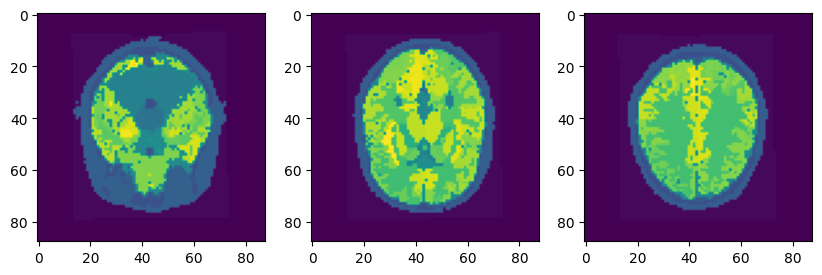

In [184]:
input_img = nib.load("./Data/P01_phantom.nii.gz").get_fdata()
# on limite les projections à trois slices pour accélérer la reconstruction
input_img = input_img [:,:,[10,20,30]]
fig, ax = plt.subplots(nrows=1,ncols=3)
for i in range(3):
    ax[i].imshow(input_img[:,:,i].T)
plt.show()

# Setup 1 : Originale

In [185]:
es1 = get_experimental_setup()

detector_type: DetectorType.PET
radius_mm: 250
pixel_size: [ 1  1 10]
pixels_per_slice_nb: 150
detector_slice_nb: 6
slice_pitch_mm: 35
image_matrix_size_mm: [264 264  90]
voxel_size_mm: [ 3  3 30]
h_fan_size: 50
detector_name: mon premier détecteur TEP
number of projections: 272700


La méthode ```Draw()``` de la classe ```ExperimentalSetupPET``` permet d'afficher les positions de la source et du détecteur, ainsi que la matrice de reconstruction. Quand on définit le paramètre```use_jupyter=1```, une figure statique est afffichée dans le notebook. Une vue interactive basée sur une visualisation VTK/openGL peut être activée en définissant le paramètre ```use_jupyter=0``` en premier argument. Le deuxième argument est la position de la caméra en mode statique. La caméra pointe toujours le centre du TR The second argument is the position of the camera in the static (```use_jupyter=1```).

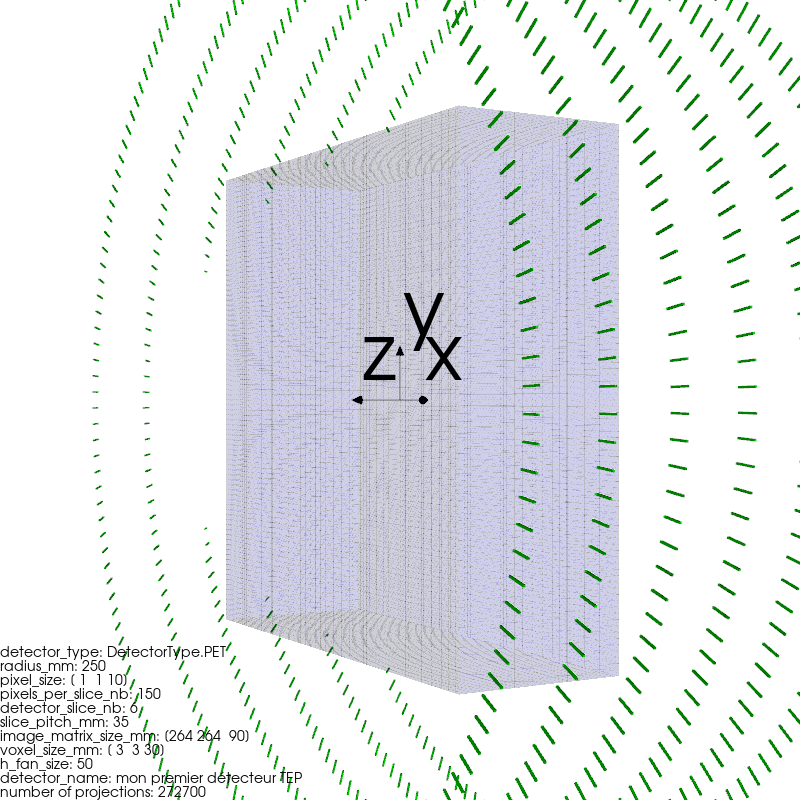

In [186]:
es1.Draw(use_jupyter=1,camera_pos_mm=(700,0,400))

## Pas de bruit (noise = 0)

### Tous les algorithmes

In [187]:
es1n0_text="Experimental Setup 1 - Noise 0"
es1n0_name = "es1n0"
es1n0_fileprefix = get_prefix(es1n0_name, es1n0_name)
es1n0_niter = 20

es1pn0 = get_projections(input_img, es1, noise=0)

reconstruct_all(
    text=es1n0_text,
    exp_setup=es1,
    projections=es1pn0,
    algorithm=algo,
    niter=es1n0_niter,
    nsubsets=20,
    initial_value=1,
    fileprefix=es1n0_fileprefix
)

Experimental Setup 1 - Noise 0
MLEM's RMS :  12.501395343364388


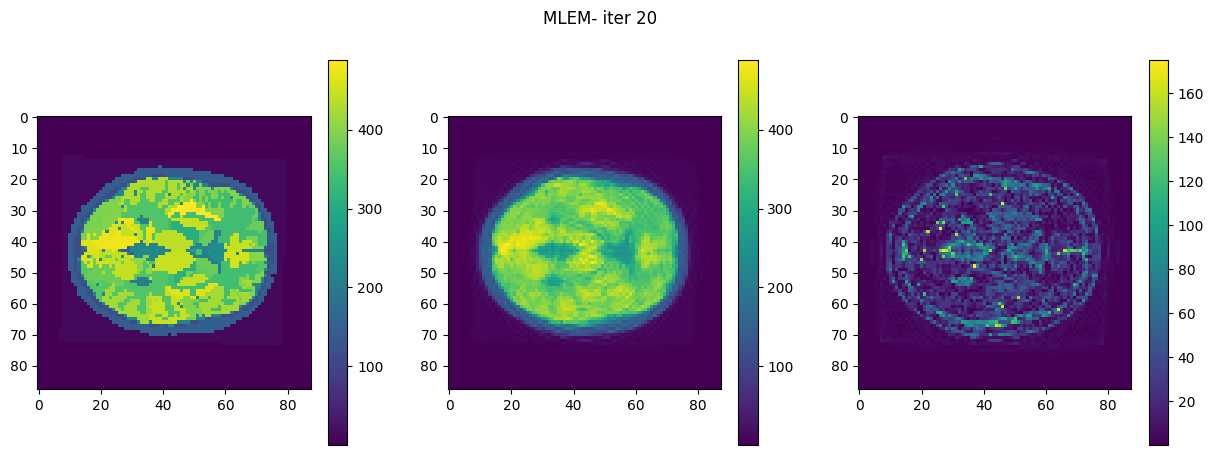

ART's RMS :  2.6302732869705445


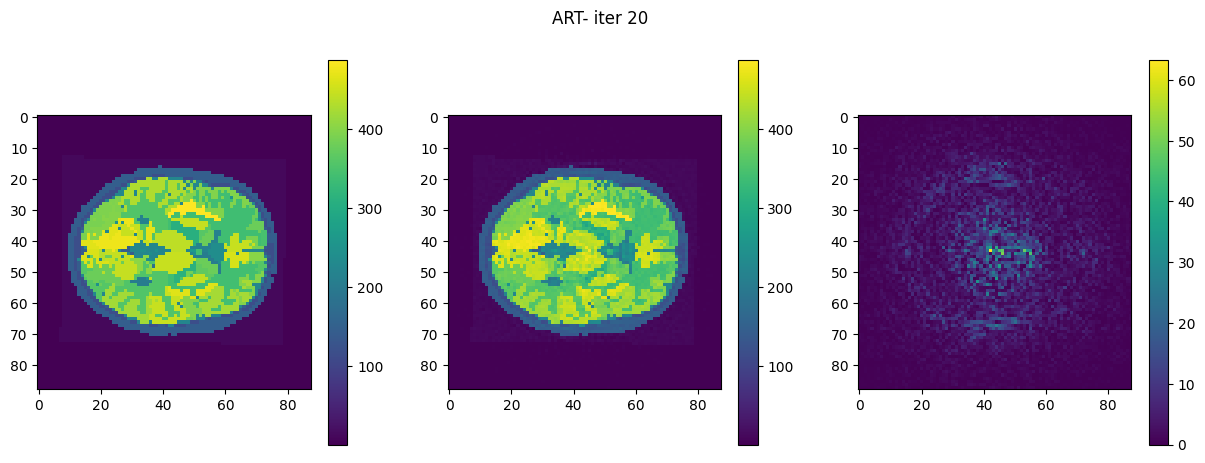

SIRT's RMS :  108.74273903039654


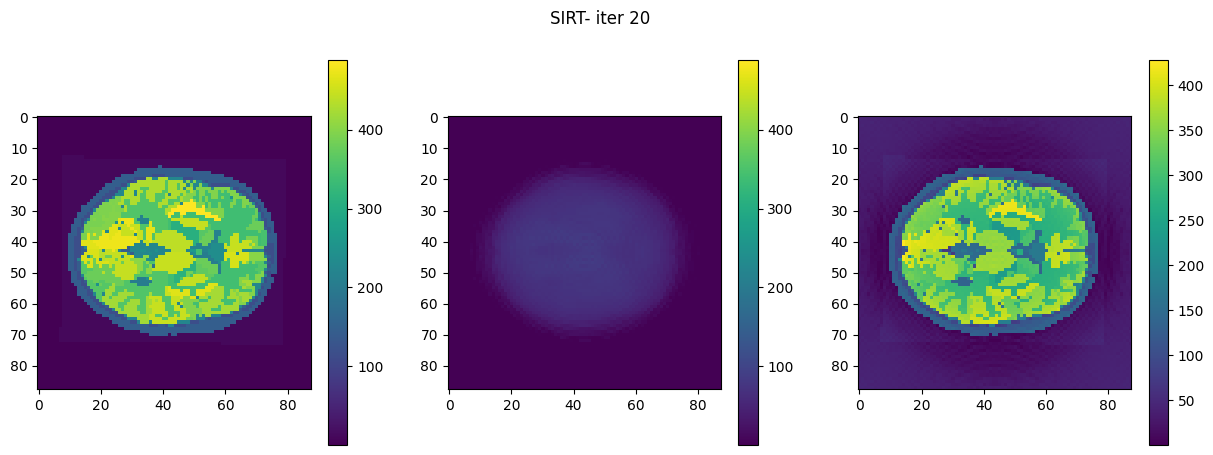

OSEM's RMS :  5.767398301500907


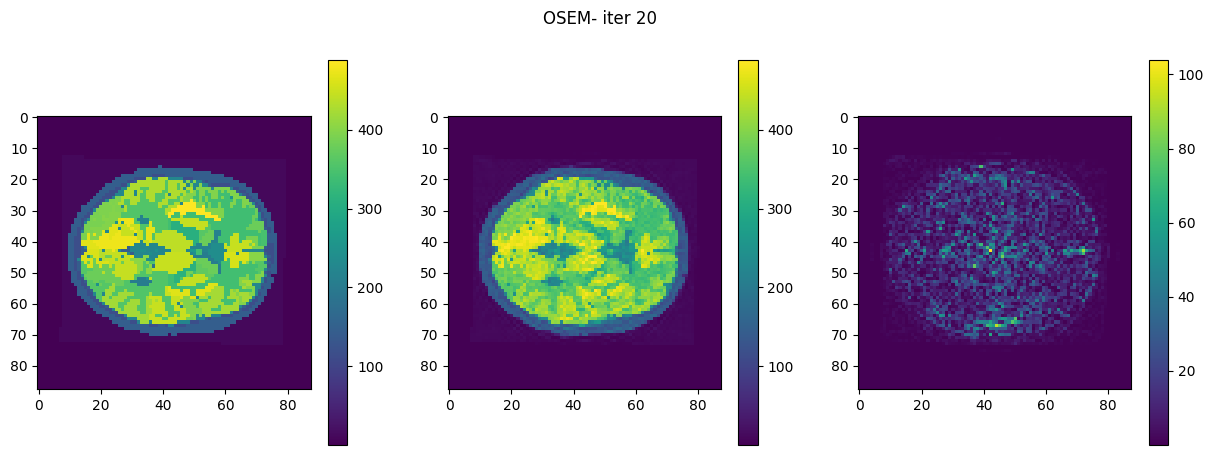

In [188]:
print_results_all(
    text=es1n0_text,
    fileprefix=es1n0_fileprefix, 
    niter=es1n0_niter,
    input_img=input_img
)

Sans aucun bruit, les meilleure algorithme est `ART` suivi de `OSEM` et `MLEM`. Par ailleurs, `SIRT` ne semble pas avoir réussi à converger. 

## Bruit Poisson (noise = 1)

### Tous les algorithmes

In [189]:
es1n1_text = "Experimental Setup 1 - Noise 1"
es1n1_fileprefix = "Results/poisson/test_"
es1n1_niter = 20

es1pn1 = get_projections(input_img, es1, noise=1)

reconstruct_all(
    text=es1n1_text,
    exp_setup=es1,
    projections=es1pn1,
    niter=es1n1_niter,
    nsubsets=20,
    initial_value=1,
    fileprefix=es1n1_fileprefix
)

Experimental Setup 1 - Noise 1
MLEM's RMS :  12.509646419453286


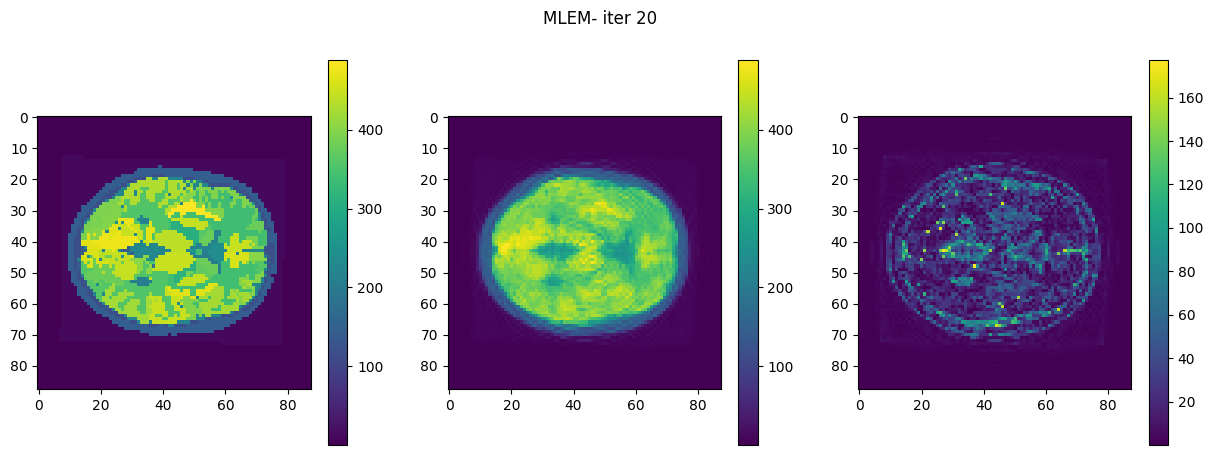

ART's RMS :  7.250581962234288


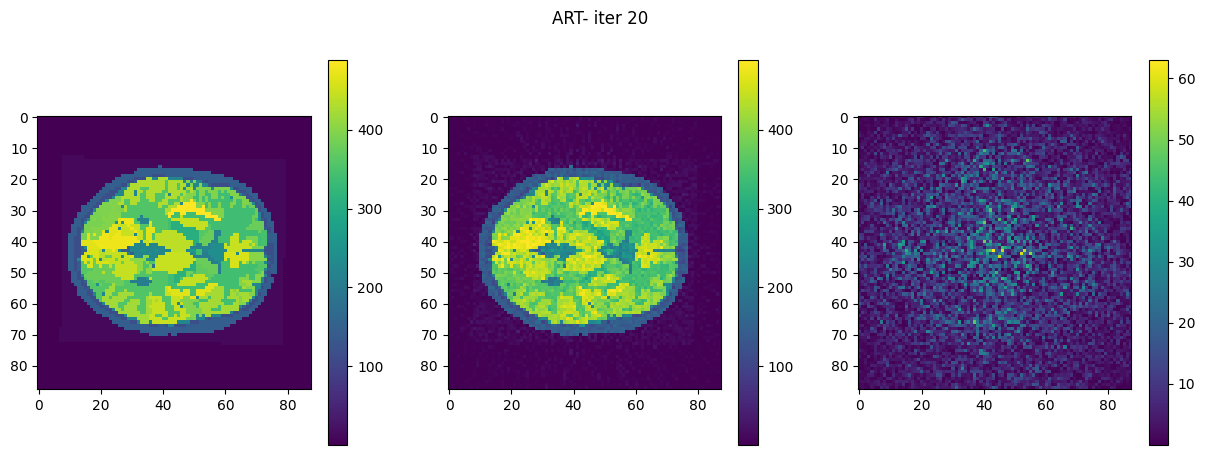

SIRT's RMS :  108.74269311456322


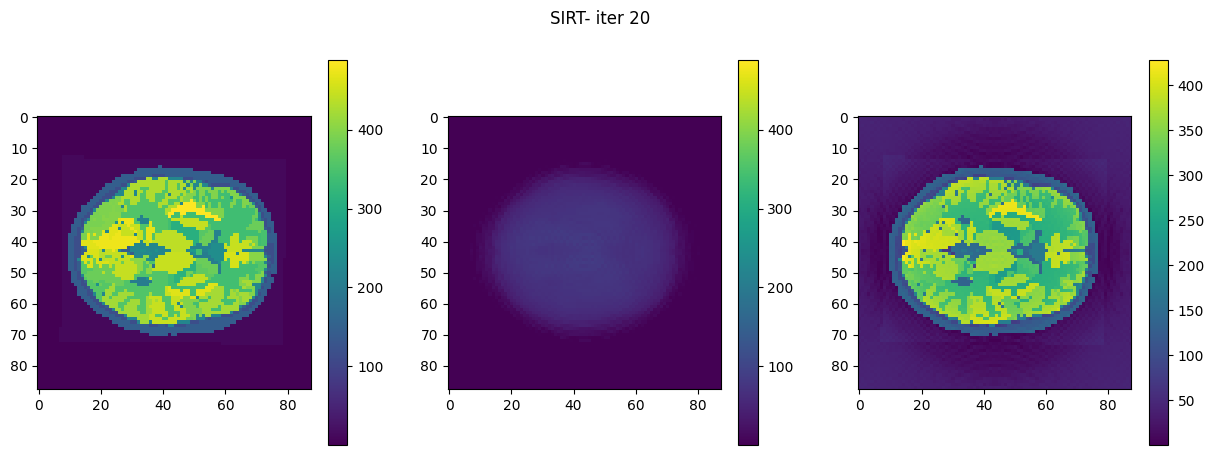

OSEM's RMS :  5.950679480652526


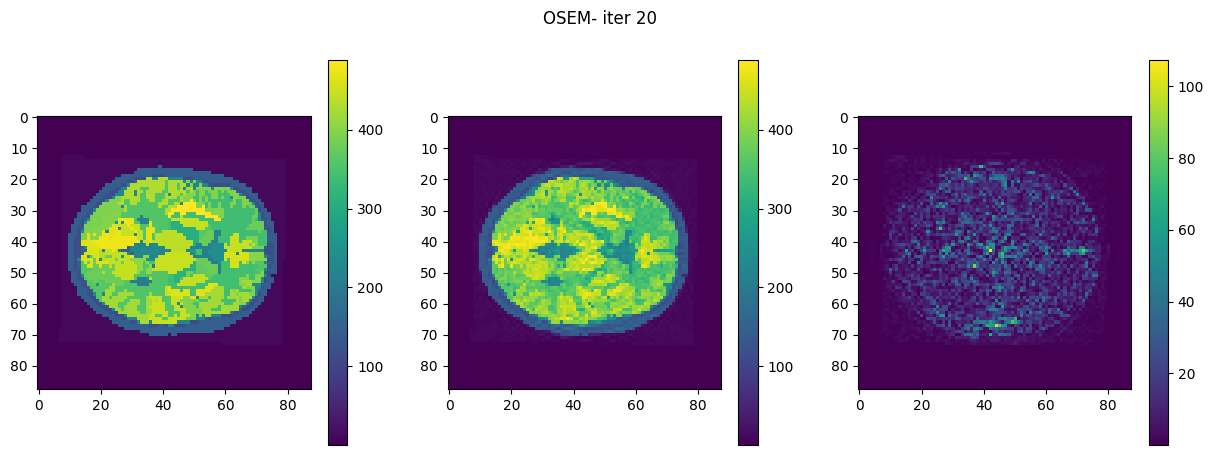

In [190]:
print_results_all(
    text=es1n1_text,
    fileprefix=es1n1_fileprefix, 
    niter=es1n1_niter,
    input_img=input_img
)

Commentaires reconstruction:

ART:
L'algorithme ART fonctionne par itération de deux étapes : projection et mise à jour. Dans l'étape de projection, les informations des projections tomographiques sont utilisées pour calculer une image approximative. Lors de l'étape de mise à jour, les images approximatives sont comparées aux projections tomographiques et les valeurs des images sont mises à jour en conséquence.

L'un des avantages de l'algorithme ART est sa capacité à produire des images de haute qualité à partir de données incomplètes. Cependant, l'algorithme est gourmand en ressources informatiques et peut nécessiter beaucoup de temps de traitement pour produire une image de haute qualité.


OBSERVATIONS:
En particulier, il faut plus de 30 secondes par itération dans les conditions initials du TP. Il sera plus utile lorsque vous travaillerez avec moins de projections.

2.5907149713082234

_______________________________________________________________

MLEM
À chaque itération, l'algorithme utilise une estimation de l'image pour calculer les projections théoriques qui seraient attendues si l'image était correcte. Cette estimation théorique est ensuite comparée aux projections mesurées, et un nouvel ensemble de valeurs de pixels de l'image est calculé à l'aide d'une technique statistique de maximum de vraisemblance.
Dans l'algorithme MLEM, de multiples itérations sont effectuées, au cours desquelles de nouvelles estimations de l'image sont calculées et comparées aux projections mesurées. Chaque itération améliore la qualité de l'image reconstruite, jusqu'à atteindre un point où l'image est considérée comme suffisamment précise.


### OSEM avec différents subsets

In [191]:
OSEM_fileprefix = "Results/poisson/test_"
OSEM_2_fileprefix = "Results/poisson/test_2_"
OSEM_3_fileprefix = "Results/poisson/test_3_"

reconstruct(
    exp_setup=es1, 
    projections=es1pn1, 
    algorithm="OSEM", 
    niter=es1n1_niter, 
    nsubsets=5, 
    initial_value=1, 
    fileprefix=OSEM_fileprefix
)

reconstruct(
    exp_setup=es1, 
    projections=es1pn1, 
    algorithm="OSEM", 
    niter=es1n1_niter, 
    nsubsets=10, 
    initial_value=1, 
    fileprefix=OSEM_2_fileprefix
)

reconstruct(
    exp_setup=es1, 
    projections=es1pn1, 
    algorithm="OSEM", 
    niter=es1n1_niter, 
    nsubsets=20, 
    initial_value=1, 
    fileprefix=OSEM_3_fileprefix
)

Experimental Setup 1 - Noise 1
OSEM : 5 subsets
OSEM's RMS :  7.502720914203174


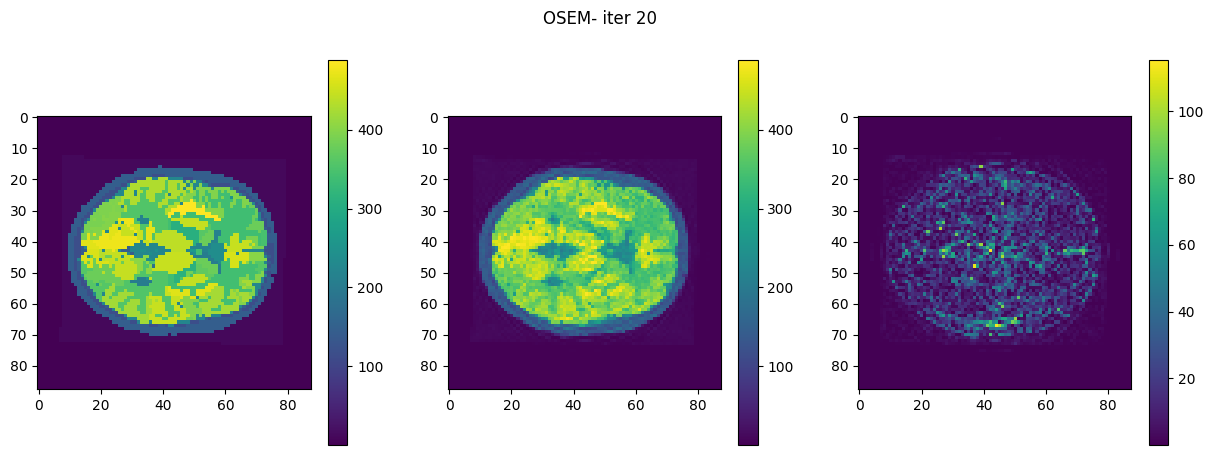

In [192]:
print(es1n1_text)
print("OSEM : 5 subsets")
print_result(OSEM_2_fileprefix, es1n1_niter, "OSEM", input_img)

Experimental Setup 1 - Noise 1
OSEM :10 subsets
OSEM's RMS :  5.950679480652526


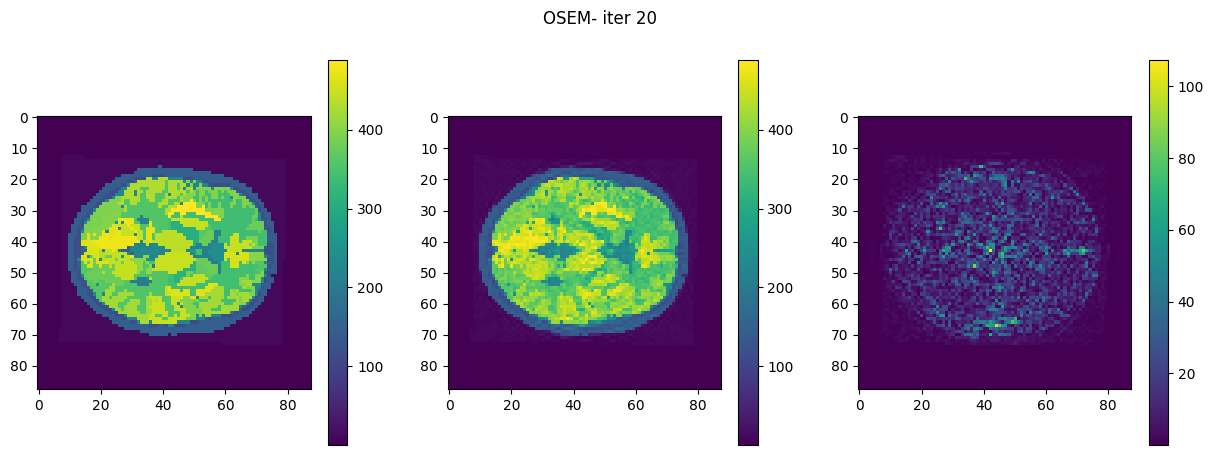

In [193]:
print(es1n1_text)
print("OSEM :10 subsets")
print_result(OSEM_fileprefix, es1n1_niter, "OSEM", input_img)

Experimental Setup 1 - Noise 1
OSEM : 20 subsets
OSEM's RMS :  4.675040711916999


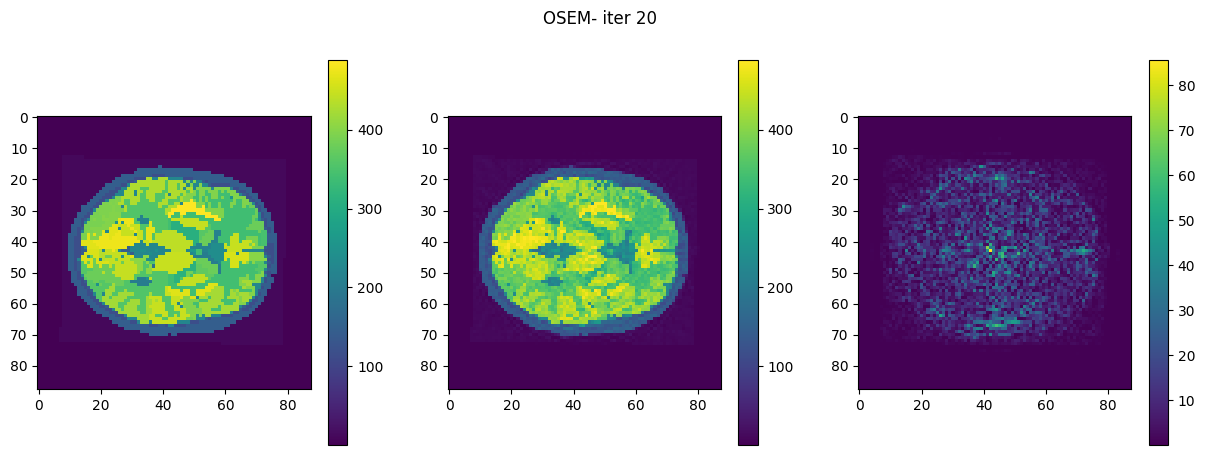

In [194]:
print(es1n1_text)
print("OSEM : 20 subsets")
print_result(OSEM_3_fileprefix, es1n1_niter, "OSEM", input_img)

Même avec peu subsets, `OSEM` a une grande performance.

### Compaison des convergences

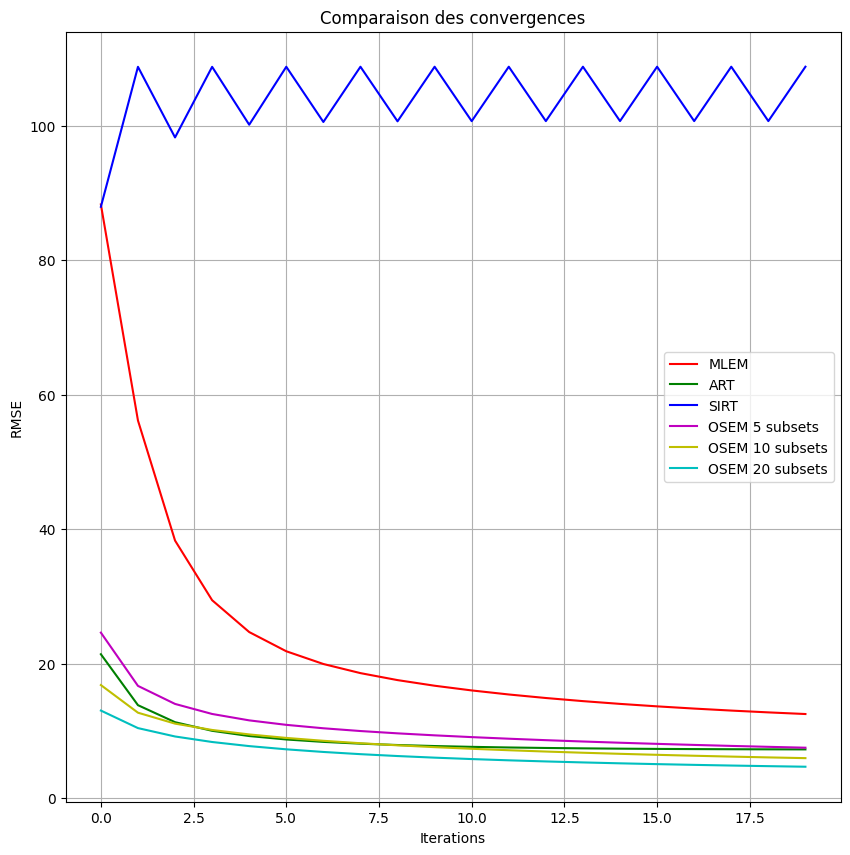

In [195]:
algos = ["MLEM", "ART", "SIRT", "OSEM", "2_OSEM", "3_OSEM"] #algo= algorithm
iters = list(range(20))
Vector_MLEM=[]
Vector_ART=[]
Vector_SIRT=[]
Vector_OSEM=[]
Vector_OSEM2=[]
Vector_OSEM3=[]
for algo in algos :
    for i in iters:
        output_img = Unpickle("Results/poisson/test_" + algo + "_iter_" + str(i+1) + ".rec")
        if algo=="MLEM" :
            Vector_MLEM.append(RMSE(input_img,output_img))
        elif algo=="ART":
            Vector_ART.append(RMSE(input_img,output_img))
        elif algo=="SIRT":
            Vector_SIRT.append(RMSE(input_img,output_img))
        elif algo=="OSEM":
            Vector_OSEM.append(RMSE(input_img,output_img))
        elif algo=="2_OSEM":
            Vector_OSEM2.append(RMSE(input_img,output_img))
        else:
            Vector_OSEM3.append(RMSE(input_img,output_img))
plt.plot(iters,Vector_MLEM,'r',label='MLEM')
plt.plot(iters,Vector_ART,'g',label='ART')
plt.plot(iters,Vector_SIRT,'b',label='SIRT')
plt.plot(iters,Vector_OSEM2,'m',label='OSEM 5 subsets')
plt.plot(iters,Vector_OSEM,'y',label='OSEM 10 subsets')
plt.plot(iters,Vector_OSEM3,'c',label='OSEM 20 subsets')

plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Comparaison des convergences')

plt.grid()
plt.legend()
plt.show()

Nous constatons que `OSEM` est normalement plus performant que les autres algorithmes sauf pour `ART` qui est meilleure que `OSEM` avec 5 subsets. Par ailleurs, même si `MLEM` a une basse performance, il arrive à converger ce qui ne passe pas avec `SIRT`, probablement suite à une mauvaise valeur initial.

## Bruit Gaussien (noise = 2)

### Tous les algorithmes

In [196]:
es1n2_text = "Experimental Setup 1 - Noise 2"
es1n2_name = "es1n2" 
es1n2_fileprefix = get_prefix(es1n2_name, es1n2_name)
es1n2_niter = 20

es1pn2 = get_projections(input_img, es1, noise=2)

reconstruct_all(
    text=es1n2_text,
    exp_setup=es1,
    projections=es1pn2,
    niter=es1n2_niter,
    nsubsets=20,
    initial_value=1,
    fileprefix=es1n2_fileprefix
)

Experimental Setup 1 - Noise 2
MLEM's RMS :  12.510937499582266


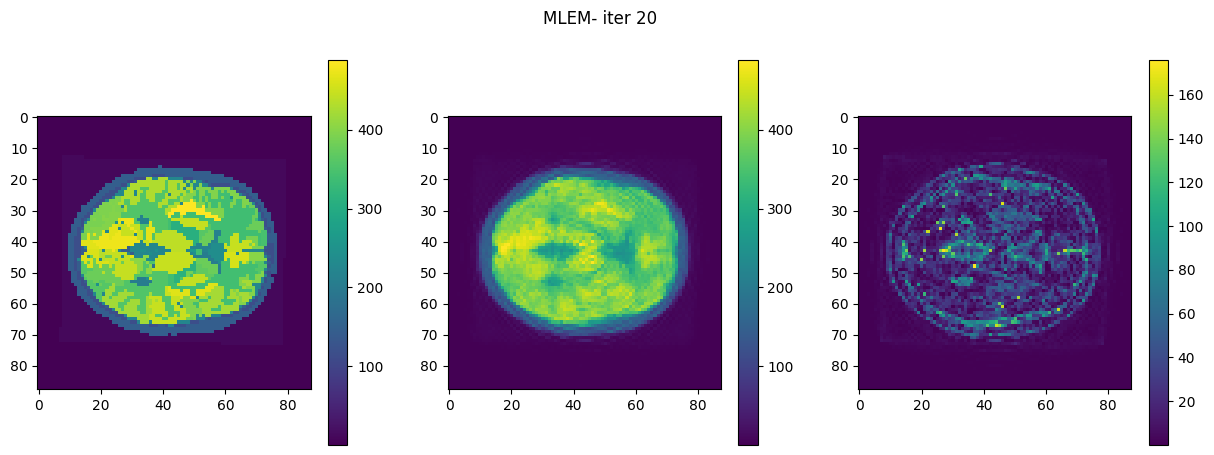

ART's RMS :  7.266763495374784


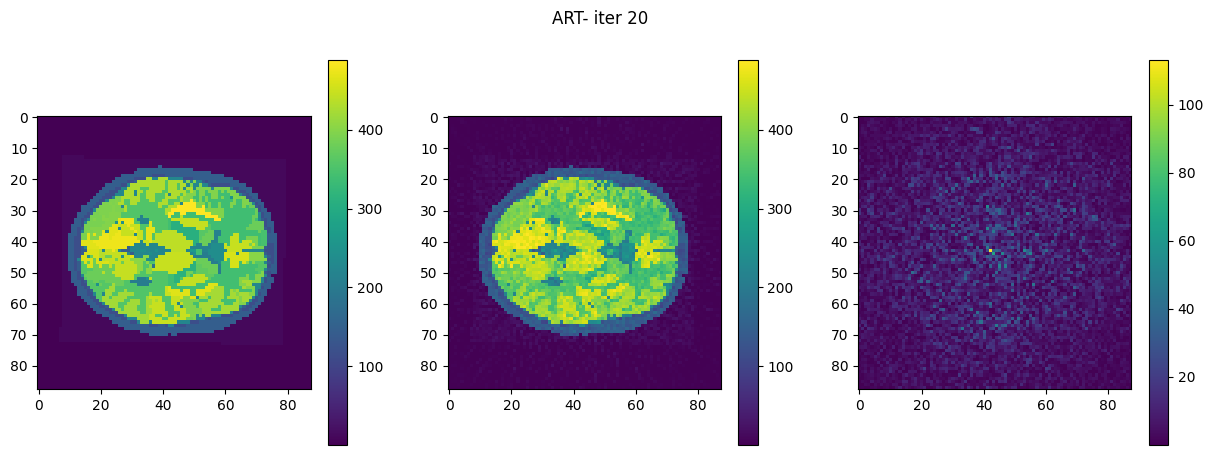

SIRT's RMS :  108.74273810178913


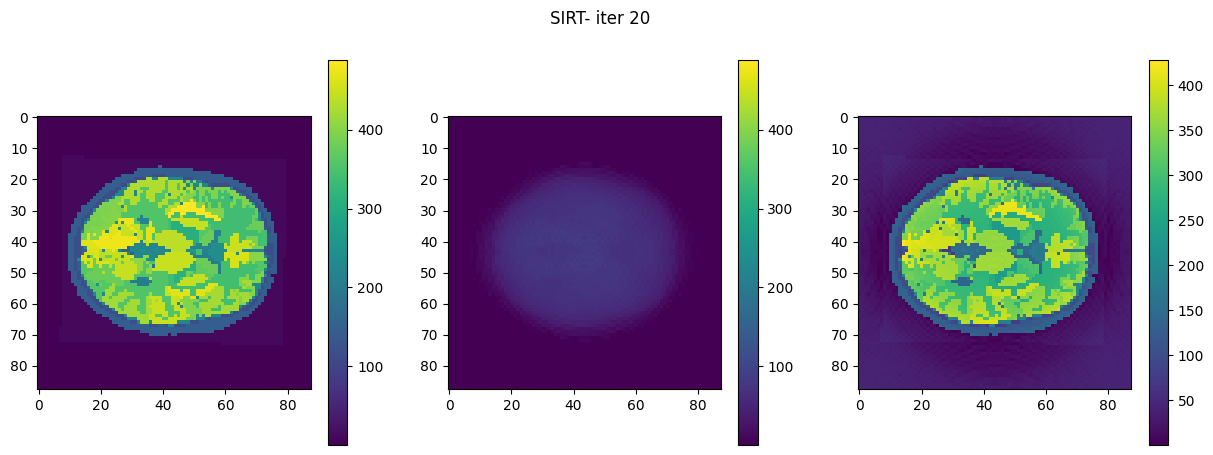

OSEM's RMS :  4.649562005121131


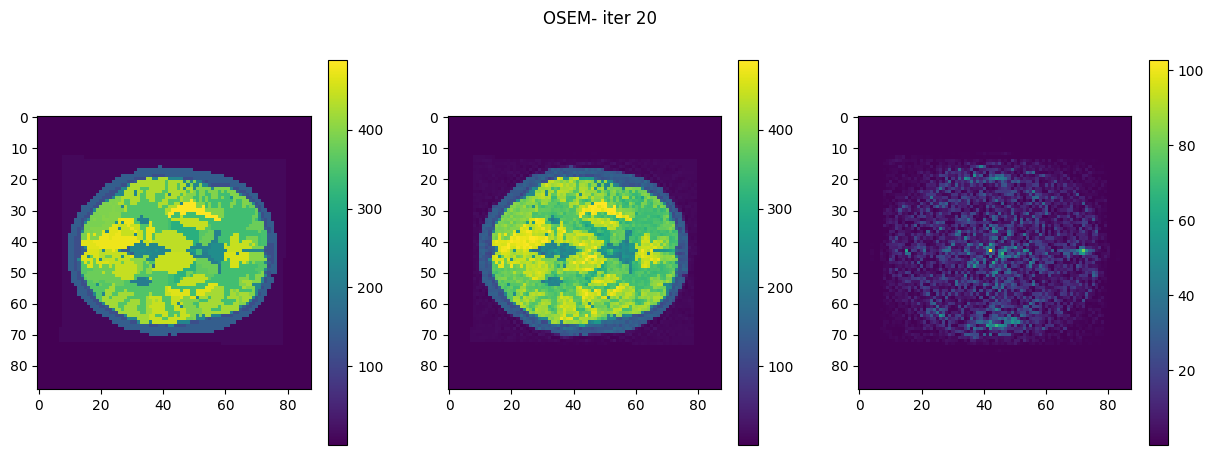

In [197]:
print_results_all(
    text=es1n2_text,
    fileprefix=es1n2_fileprefix, 
    niter=es1n2_niter,
    input_img=input_img
)

Nous constatons que le meilleure algorithme de reconstruction, avec cette parametrisation du detecteur, c'est l'algorithme `OSEM` suivi de l'`ART` et le `MLEM`. Par contre, l'algorithme `SIRT` donne des très mauvaises résultats.

### Variation d'intensité

In [198]:
es1n2LowI_name = "es1n2LowI"
es1n2LowI_fileprefix = get_prefix(es1n2_name, es1n2LowI_name)

In [199]:
low_input_img = input_img*0.1

es1pn2LowI = get_projections(low_input_img, es1, noise=2)

reconstruct(
    exp_setup=es1, 
    projections=es1pn2LowI, 
    algorithm=bestAlgo, 
    niter=es1n2_niter, 
    nsubsets=20, 
    initial_value=1, 
    fileprefix=es1n2LowI_fileprefix
)

Experimental Setup 1 - Noise 2
Low intensity
OSEM's RMS :  0.6976461423918681


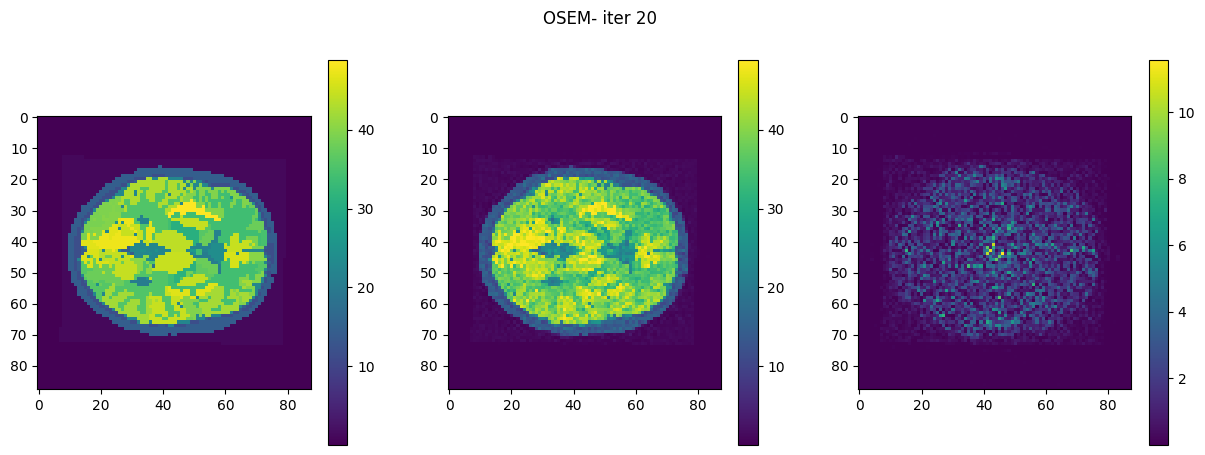

In [200]:
print(es1n2_text)
print("Low intensity")
print_result(es1n2LowI_fileprefix, es1n2_niter, bestAlgo, low_input_img)

Experimental Setup 1 - Noise 2
Normal intensity
OSEM's RMS :  4.649562005121131


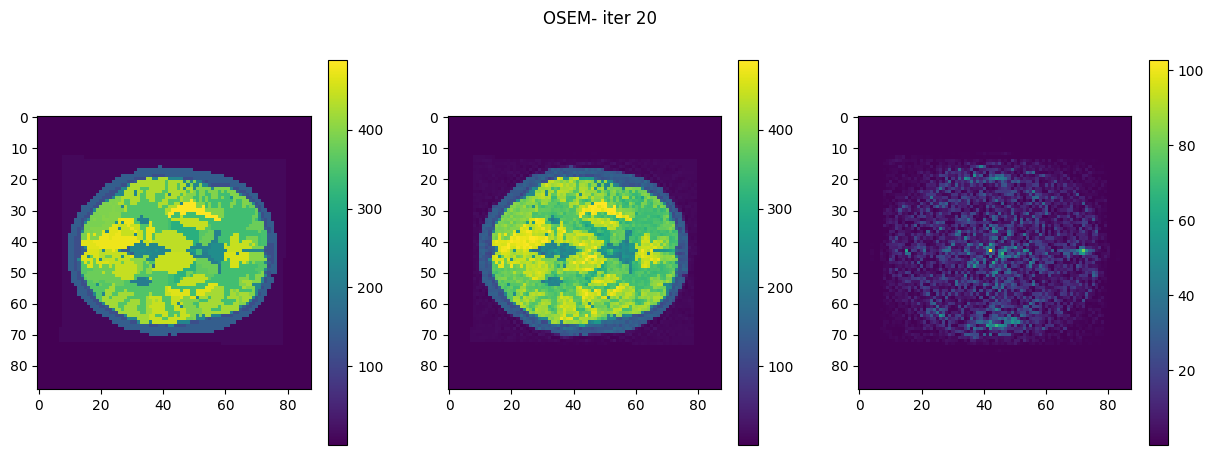

In [201]:
print(es1n2_text)
print("Normal intensity")
print_result(es1n2_fileprefix, es1n2_niter, bestAlgo, input_img)

Curieusement, `OSEM` donne des meilleurs résultats avec une image plus bruitée. Cela peut s'expliquer si nous pensons que l'image plus bruitée est le résultat partiel d'une algorithme de reconstruction tel que `OSEM`.

### Variations  d'iterations

Experimental Setup 1 - Noise 2
Compare iterations
MLEM's RMS :  88.26486777138506


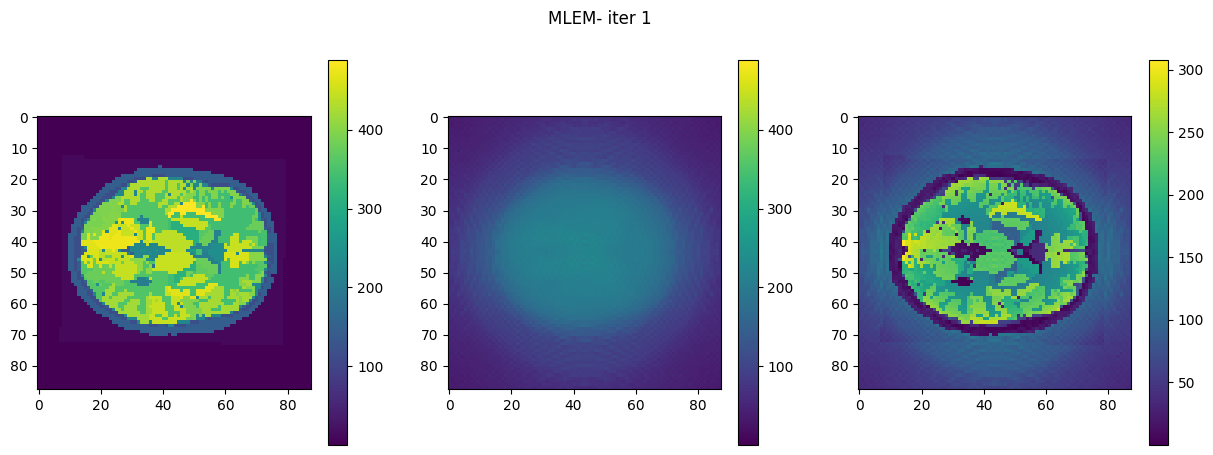

MLEM's RMS :  24.693297112611678


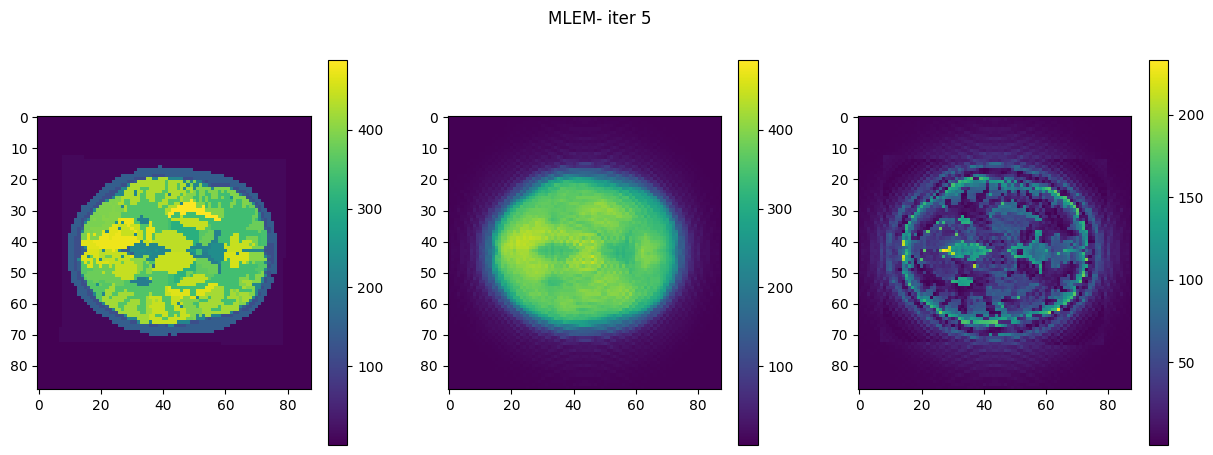

MLEM's RMS :  16.715119639653967


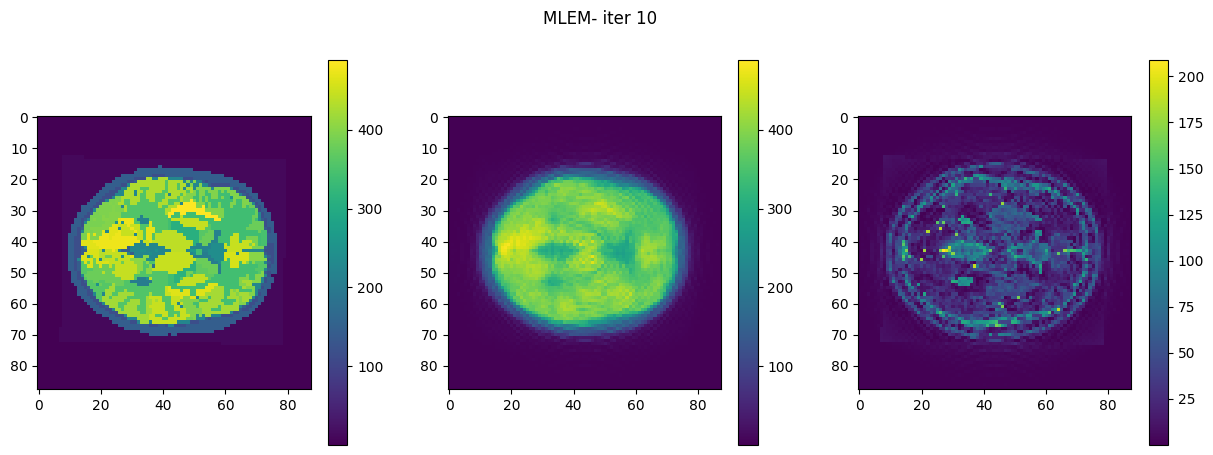

MLEM's RMS :  14.01677254055718


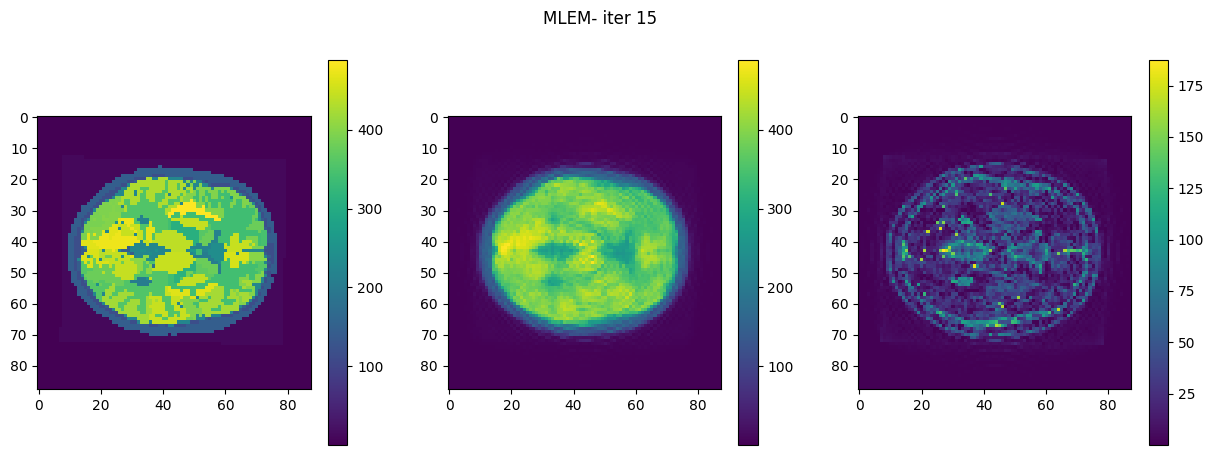

MLEM's RMS :  12.510937499582266


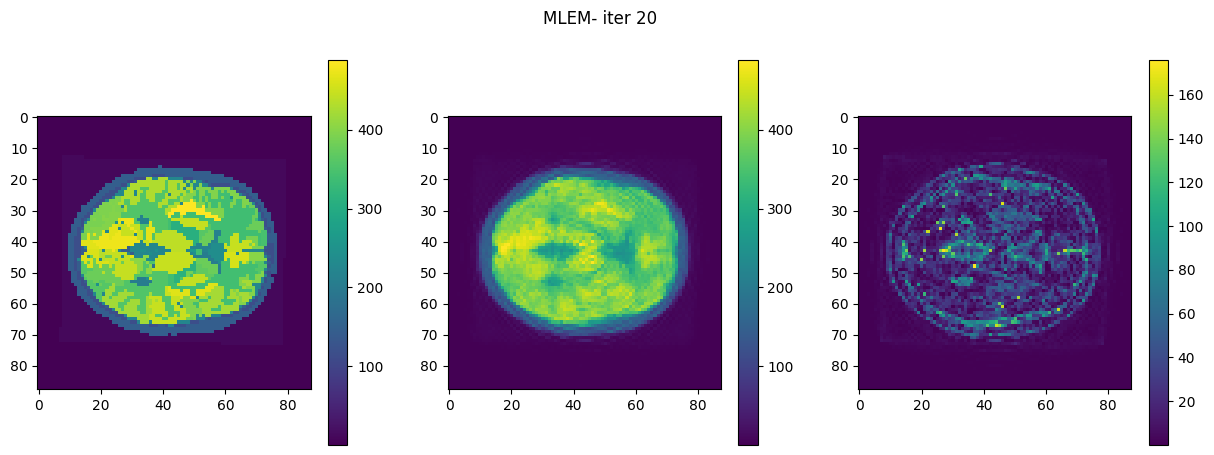

ART's RMS :  21.637844702013897


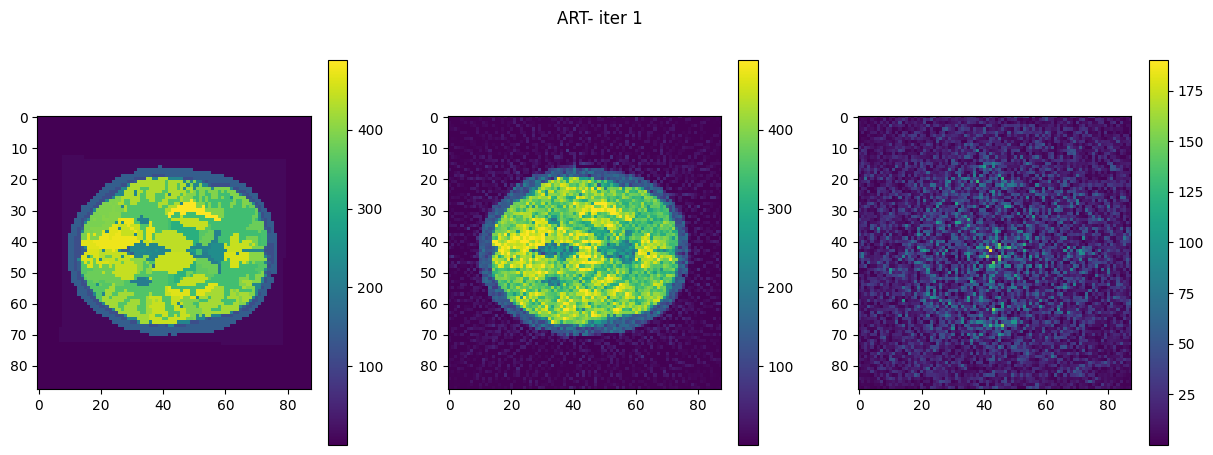

ART's RMS :  9.293032039046393


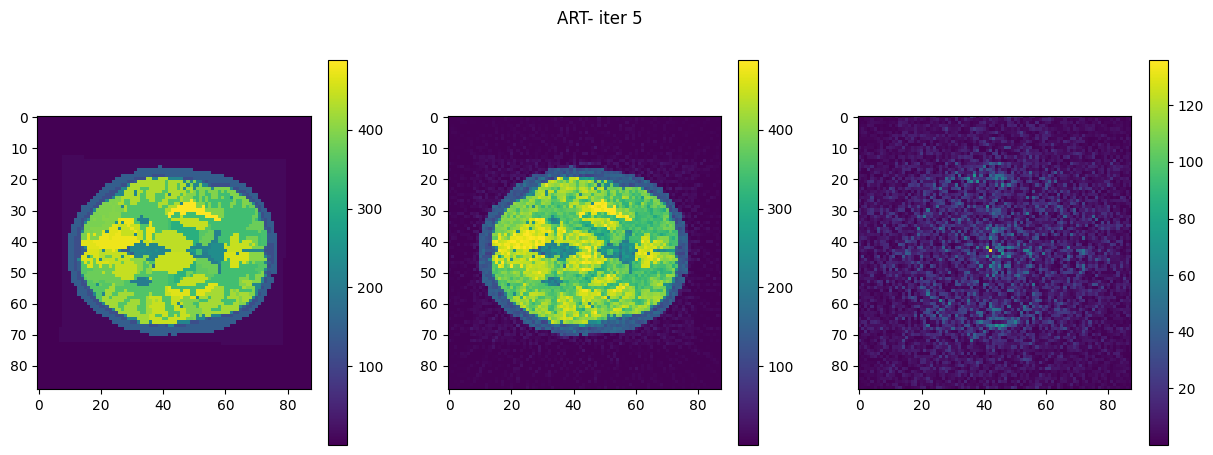

ART's RMS :  7.781165372387655


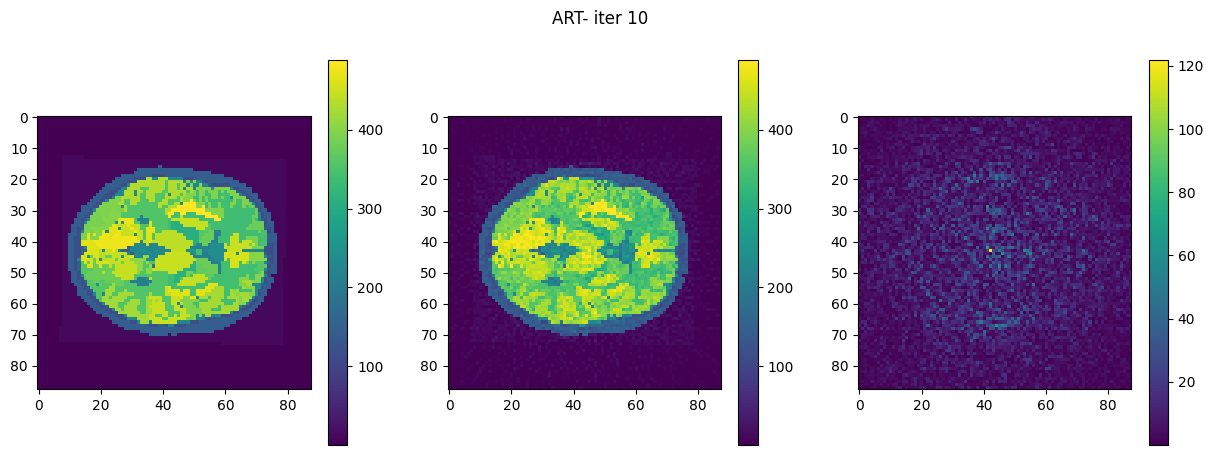

ART's RMS :  7.385155076248409


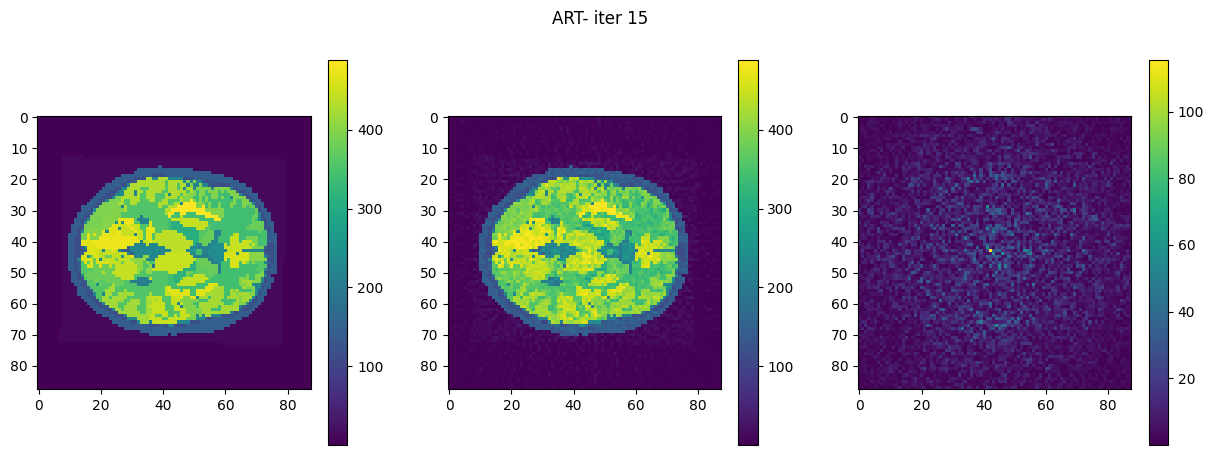

ART's RMS :  7.266763495374784


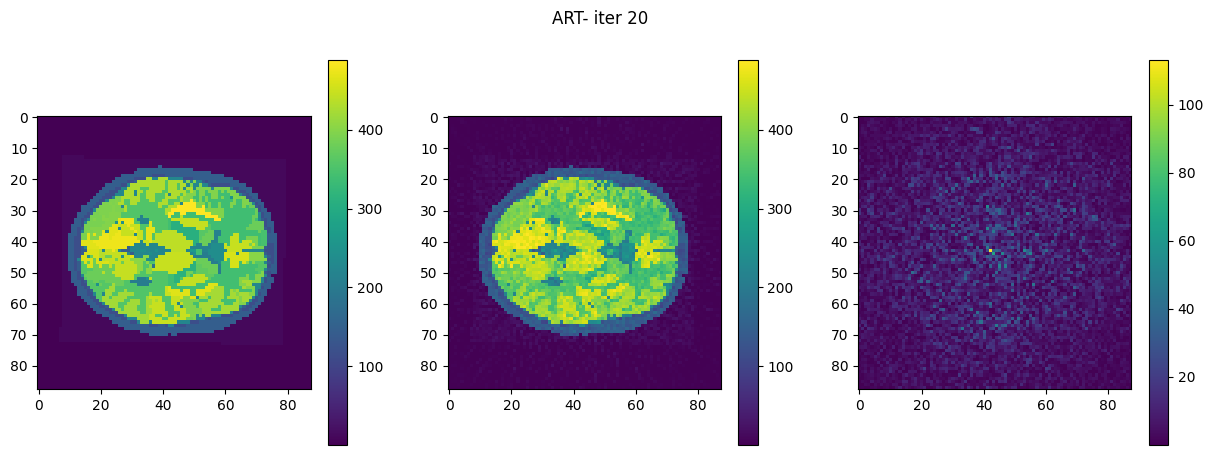

SIRT's RMS :  87.92239771606565


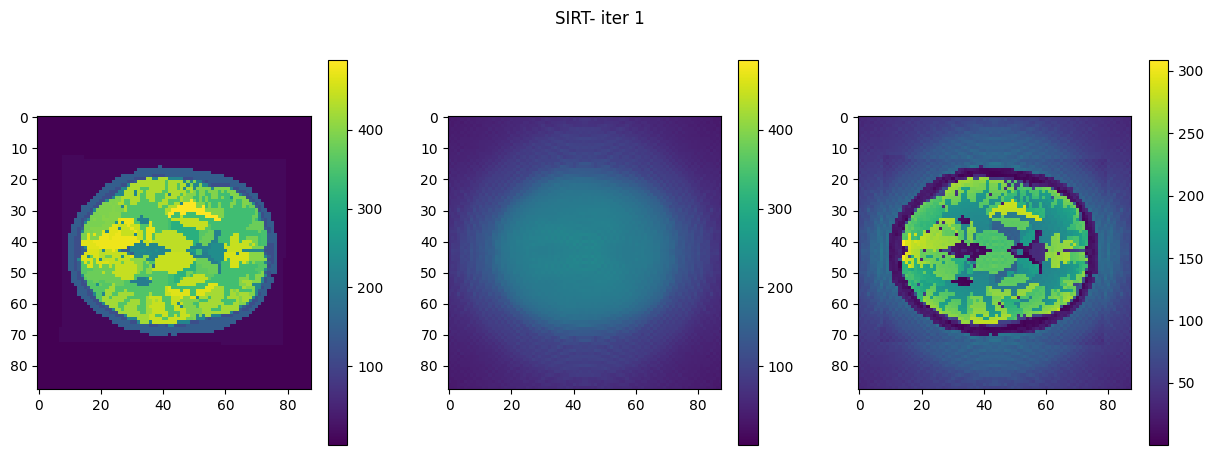

SIRT's RMS :  100.12193463837424


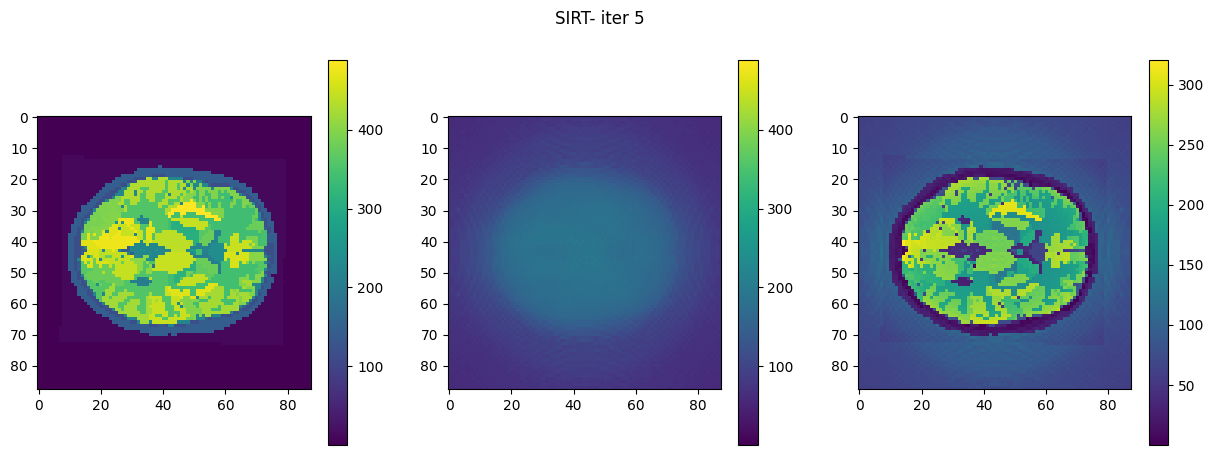

SIRT's RMS :  108.74172533415964


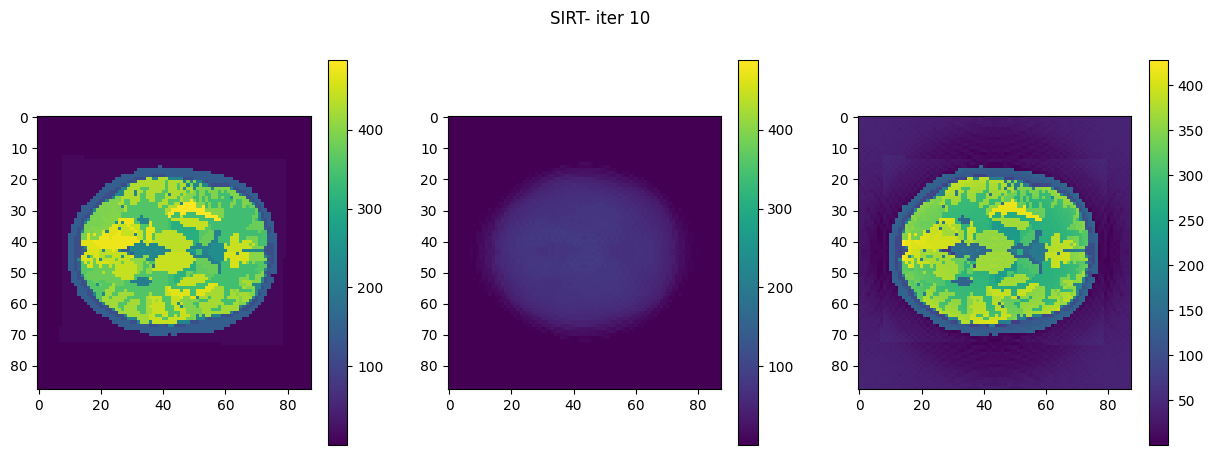

SIRT's RMS :  100.66045871795934


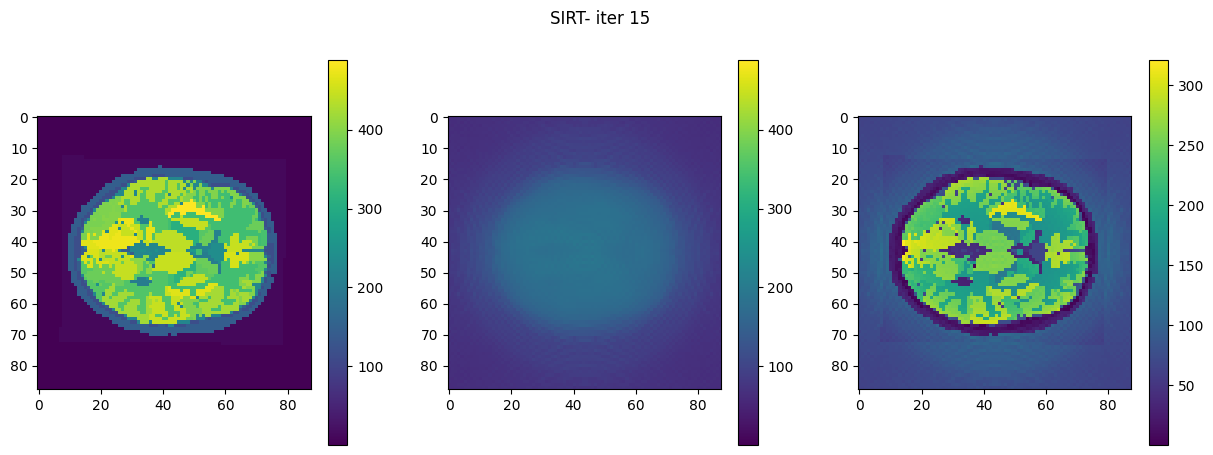

SIRT's RMS :  108.74273810178913


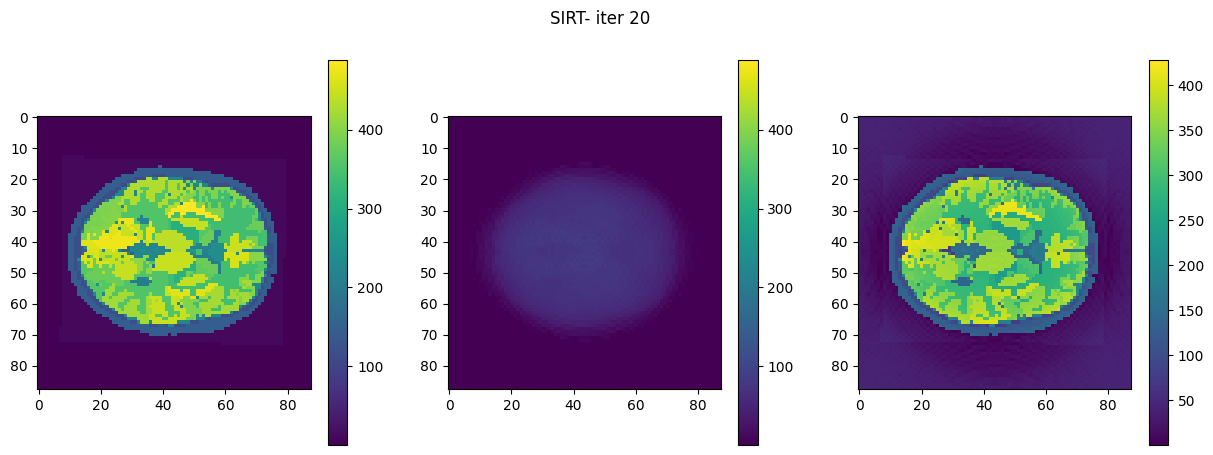

OSEM's RMS :  13.046437169770476


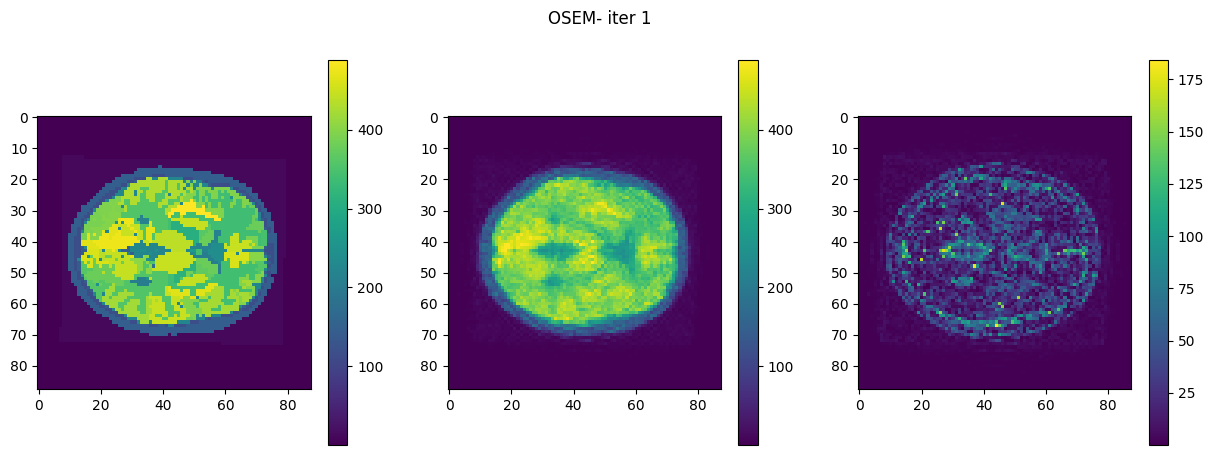

OSEM's RMS :  7.715203802060218


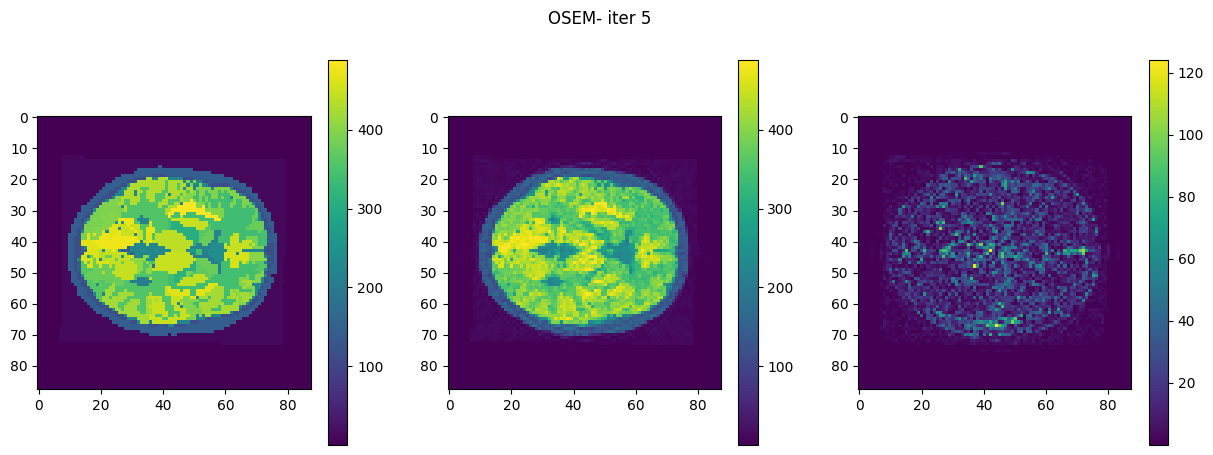

OSEM's RMS :  5.994775670473525


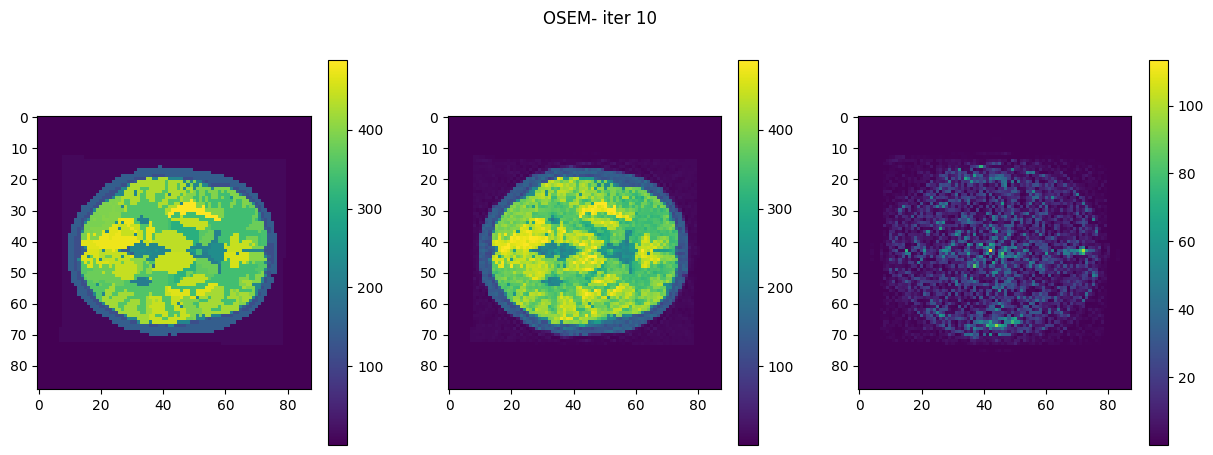

OSEM's RMS :  5.152961851972113


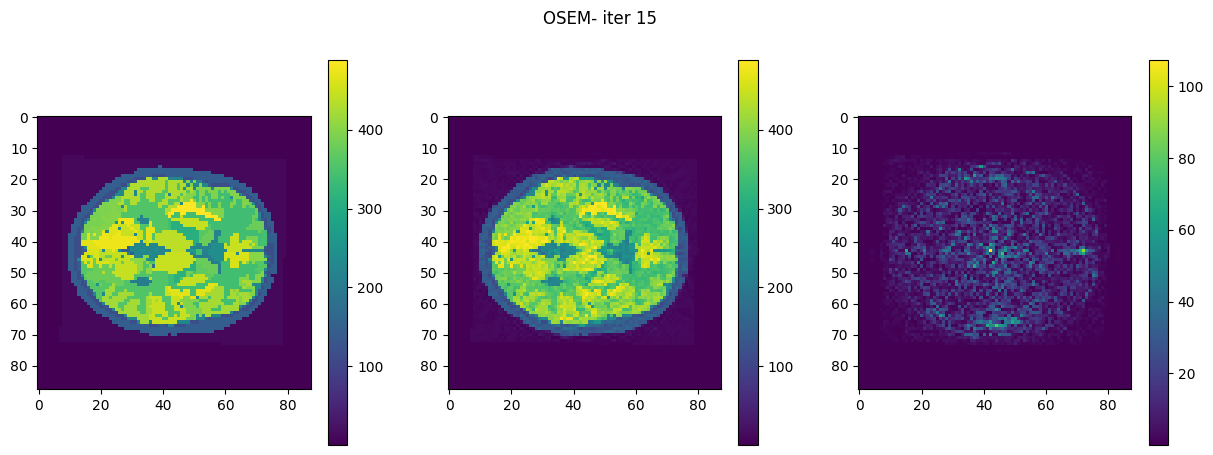

OSEM's RMS :  4.649562005121131


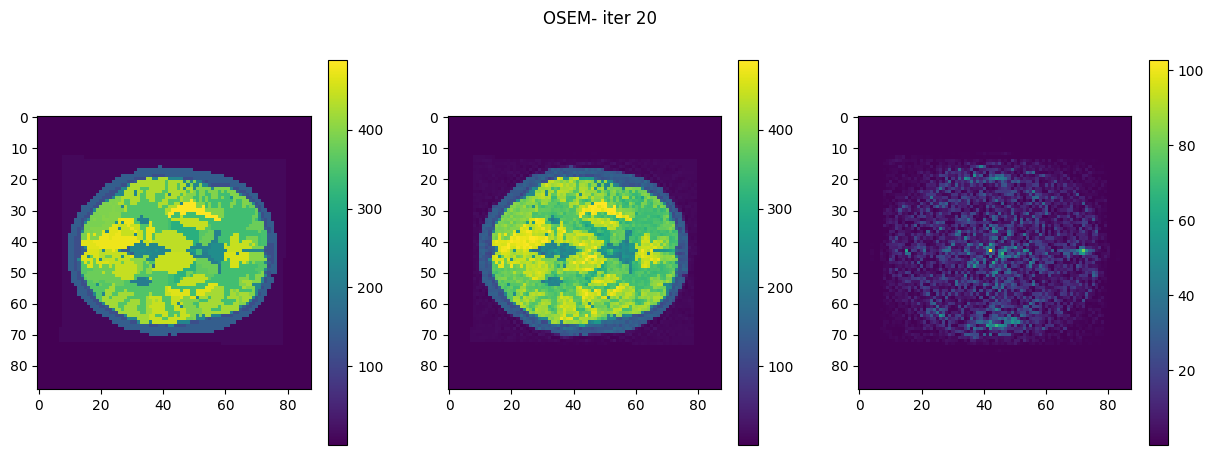

In [202]:
print(es1n2_text)
print("Compare iterations")
for algo in ALL_ALGOS:
    for i_iter in range(0, es1n2_niter+1, 5):
        if i_iter == 0:
            i_iter += 1
        print_result(es1n2_fileprefix, i_iter, algo, input_img)

Nous constatons que `OSEM` et `ART` ont des bonnes résultats dès les premières iterations. Par contre, `MLEM` a besoin de plusiers iterations avant d'arriver à un résultat similaire. Par ailleurs, `SIRT` semble n'améliore pas et semble être en train d'osciller autour des deux mauvaise résultats.

## Slice Pitch

### Setup 2 : Petit Slice Pitch

In [203]:
es2 = get_experimental_setup( 
    slice_pitch_mm=3,
    detector_name="Detecteur 2 : Petit Slice Pitch"
)

detector_type: DetectorType.PET
radius_mm: 250
pixel_size: [ 1  1 10]
pixels_per_slice_nb: 150
detector_slice_nb: 6
slice_pitch_mm: 3
image_matrix_size_mm: [264 264  90]
voxel_size_mm: [ 3  3 30]
h_fan_size: 50
detector_name: Detecteur 2 : Petit Slice Pitch
number of projections: 272700


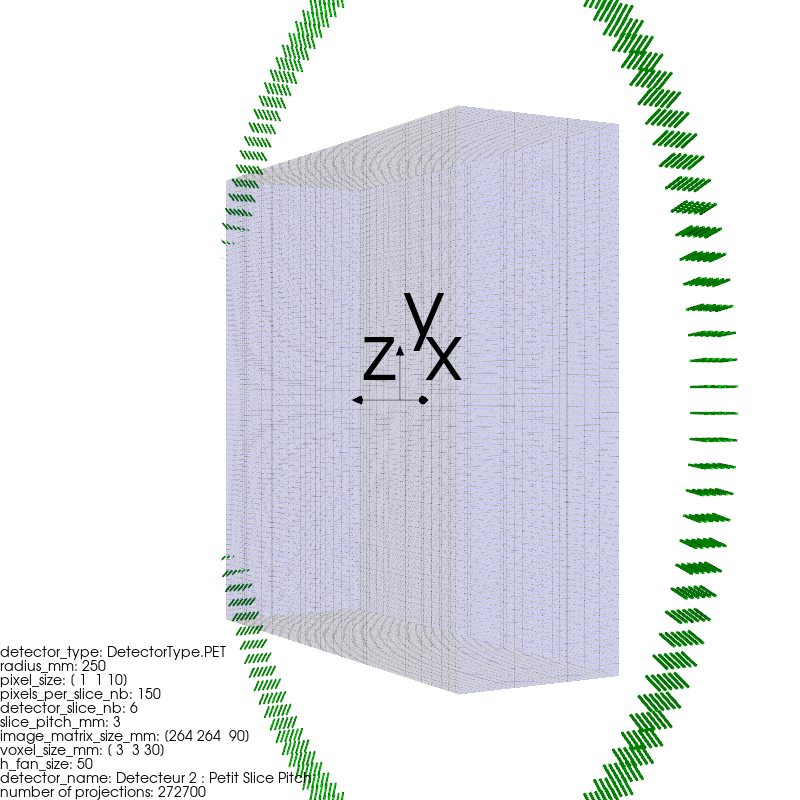

In [204]:
es2.Draw(use_jupyter=1,camera_pos_mm=(700,0,400))

In [205]:
es2n2_text="Experimental Setup 2 - Noise 2 - Petit Slice Pich"
es2n2_name = "es2n2"
es2n2_fileprefix = get_prefix(es2n2_name, es2n2_name)
es2n2_niter = 20

es2pn2 = get_projections(input_img, es2, noise=2)

reconstruct(
    exp_setup=es2, 
    projections=es2pn2, 
    algorithm="OSEM", 
    niter=es2n2_niter, 
    nsubsets=20, 
    initial_value=1, 
    fileprefix=es2n2_fileprefix
)

### Setup 3 : Grand Slice Pitch

In [206]:
es3 = get_experimental_setup(
    slice_pitch_mm=67,
    detector_name="Detecteur 3 : Grand Slice Pitch"
)

detector_type: DetectorType.PET
radius_mm: 250
pixel_size: [ 1  1 10]
pixels_per_slice_nb: 150
detector_slice_nb: 6
slice_pitch_mm: 67
image_matrix_size_mm: [264 264  90]
voxel_size_mm: [ 3  3 30]
h_fan_size: 50
detector_name: Detecteur 3 : Grand Slice Pitch
number of projections: 272700


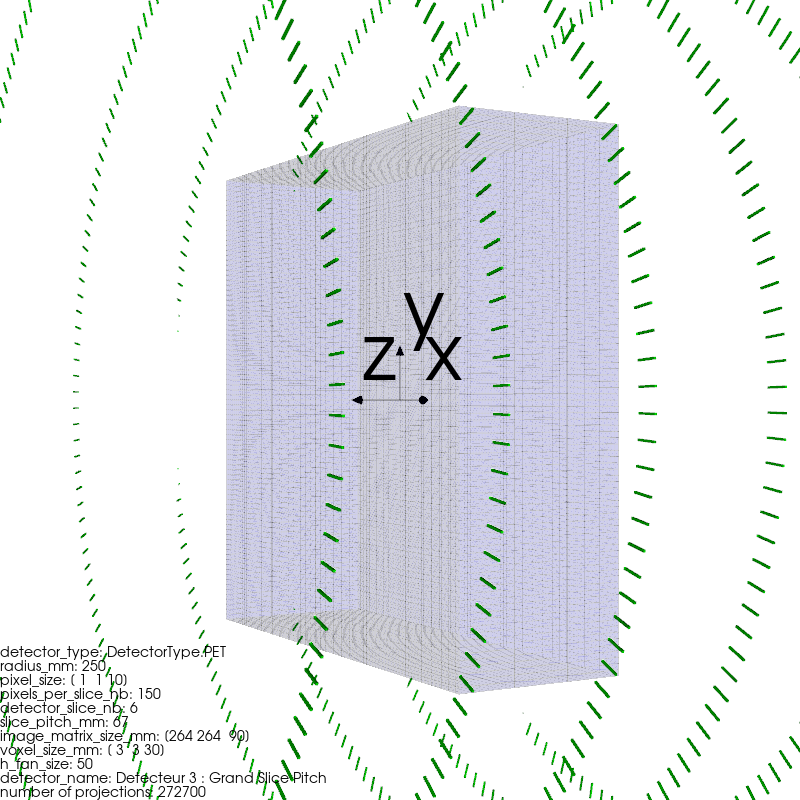

In [207]:
es3.Draw(use_jupyter=1,camera_pos_mm=(700,0,400))

In [208]:
es3n2_text="Experimental Setup 3 - Noise 2 - Grand Slice Pich"
es3n2_name = "es3n2"
es3n2_fileprefix = get_prefix(es3n2_name, es3n2_name)
es3n2_niter = 20

es3pn2 = get_projections(input_img, es3, noise=2)

reconstruct(
    exp_setup=es3, 
    projections=es3pn2, 
    algorithm="OSEM", 
    niter=es3n2_niter, 
    nsubsets=20, 
    initial_value=1, 
    fileprefix=es3n2_fileprefix
)

### Comparaison

Experimental Setup 2 - Noise 2 - Petit Slice Pich
OSEM's RMS :  71.07465038285143


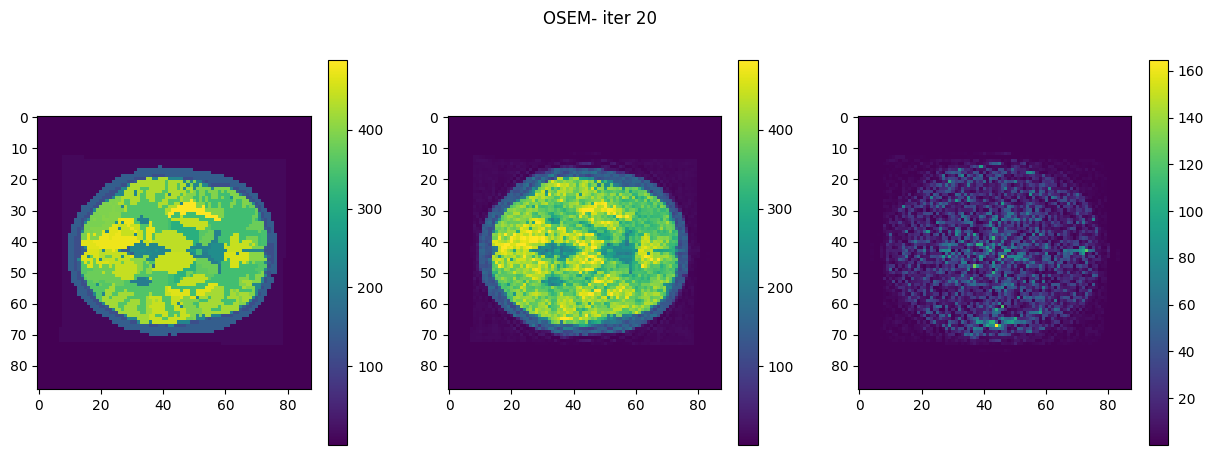

In [209]:
print(es2n2_text)
print_result(es2n2_fileprefix, es2n2_niter, "OSEM", input_img)

Experimental Setup 1 - Noise 2
OSEM's RMS :  4.649562005121131


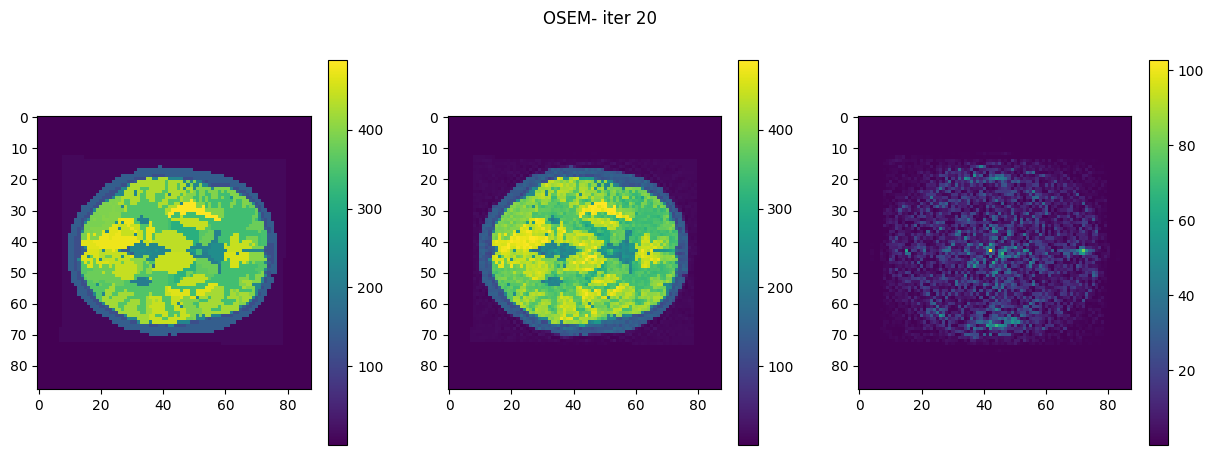

In [210]:
print(es1n2_text)
print_result(es1n2_fileprefix, es1n2_niter, "OSEM", input_img)

Experimental Setup 3 - Noise 2 - Grand Slice Pich
OSEM's RMS :  1.9875639999570278


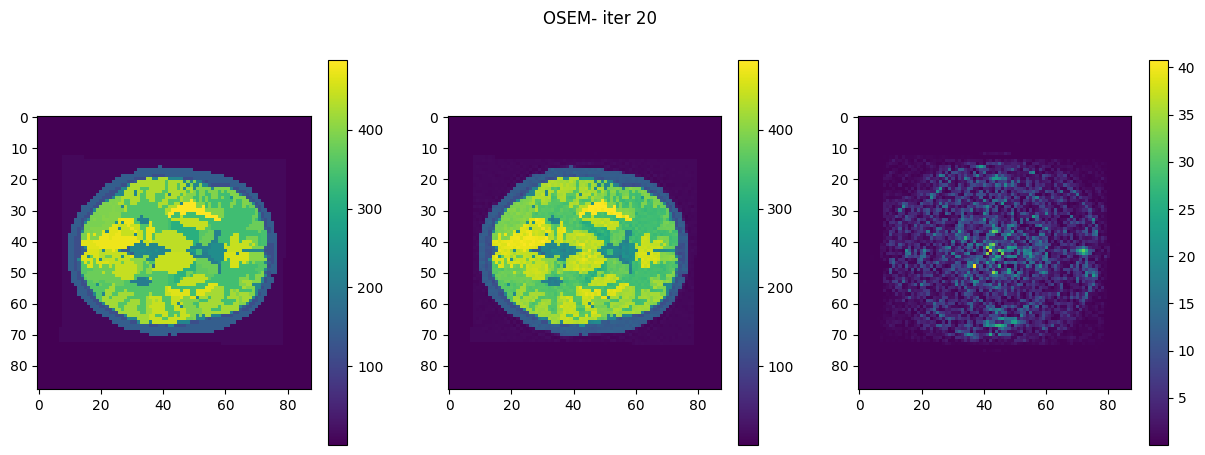

In [211]:
print(es3n2_text)
print_result(es3n2_fileprefix, es3n2_niter, "OSEM", input_img)

Au fur et à mesure que nous augmentons la taille du `slice pitch`, la reconstruction s'approche plus à l'image originale.

## Nombre de Coronnes

### Setup 4 : Moins Coronnes

In [212]:
es4 = get_experimental_setup(
    detector_slice_nb=2, 
    detector_name="Detecteur 4 : Moins Coronnes"
)

detector_type: DetectorType.PET
radius_mm: 250
pixel_size: [ 1  1 10]
pixels_per_slice_nb: 150
detector_slice_nb: 2
slice_pitch_mm: 35
image_matrix_size_mm: [264 264  90]
voxel_size_mm: [ 3  3 30]
h_fan_size: 50
detector_name: Detecteur 4 : Moins Coronnes
number of projections: 30300


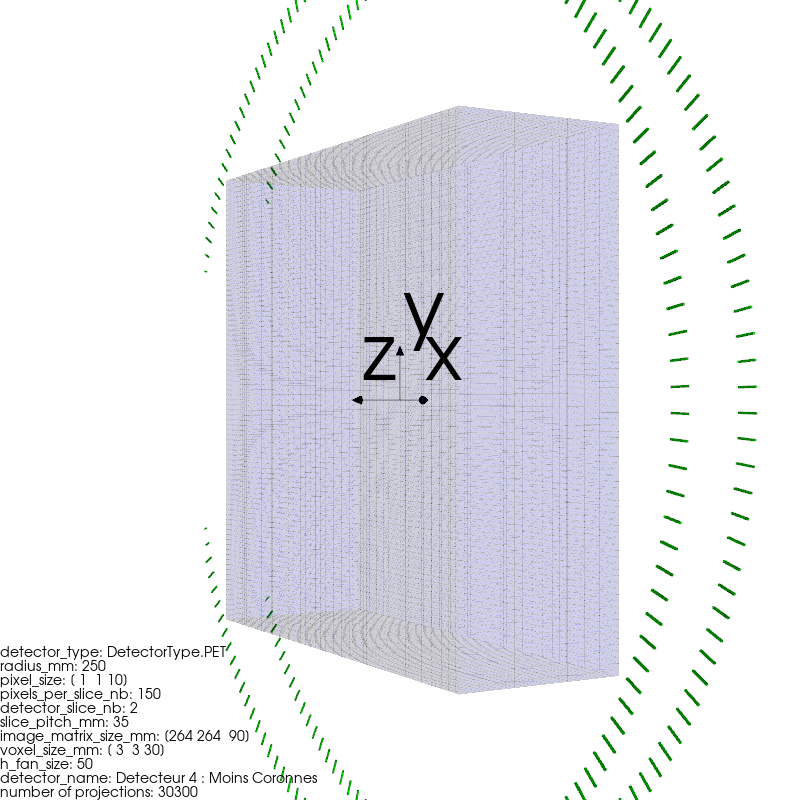

In [213]:
es4.Draw(use_jupyter=1,camera_pos_mm=(700,0,400))

In [214]:
es4n2_text="Experimental Setup 4 - Noise 2 - Moins Coronnes"
es4n2_name = "es4n2"
es4n2_fileprefix = get_prefix(es4n2_name, es4n2_name)
es4n2_niter = 20

es4pn2 = get_projections(input_img, es4, noise=2)

reconstruct(
    exp_setup=es4, 
    projections=es4pn2, 
    algorithm="OSEM", 
    niter=es4n2_niter, 
    nsubsets=20, 
    initial_value=1, 
    fileprefix=es4n2_fileprefix
)

### Setup 5 : Plus Coronnes

In [215]:
es5 = get_experimental_setup(
    detector_slice_nb=12, 
    detector_name="Detecteur 5 : Plus Coronnes"
)

detector_type: DetectorType.PET
radius_mm: 250
pixel_size: [ 1  1 10]
pixels_per_slice_nb: 150
detector_slice_nb: 12
slice_pitch_mm: 35
image_matrix_size_mm: [264 264  90]
voxel_size_mm: [ 3  3 30]
h_fan_size: 50
detector_name: Detecteur 5 : Plus Coronnes
number of projections: 1090800


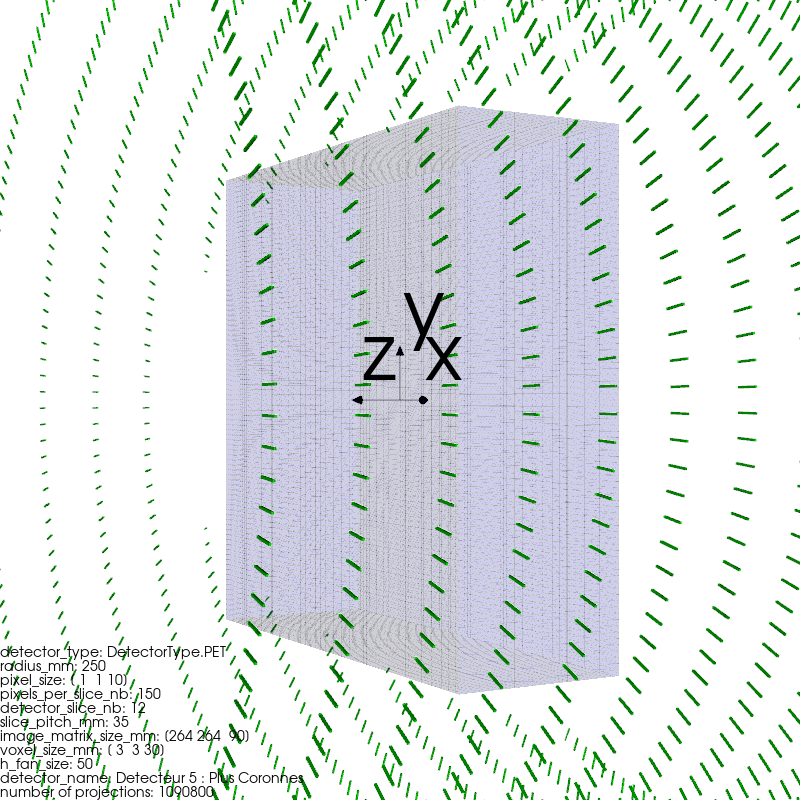

In [216]:
es5.Draw(use_jupyter=1,camera_pos_mm=(700,0,400))

In [217]:
es5n2_text="Experimental Setup 5 - Noise 2 - Plus Coronnes"
es5n2_name = "es5n2"
es5n2_fileprefix = get_prefix(es5n2_name, es5n2_name)
es5n2_niter = 20

es5pn2 = get_projections(input_img, es5, noise=2)

reconstruct(
    exp_setup=es5, 
    projections=es5pn2, 
    algorithm="OSEM", 
    niter=es5n2_niter, 
    nsubsets=20, 
    initial_value=1, 
    fileprefix=es5n2_fileprefix
)

### Comparaison

Experimental Setup 4 - Noise 2 - Moins Coronnes
OSEM's RMS :  119.19489595585719


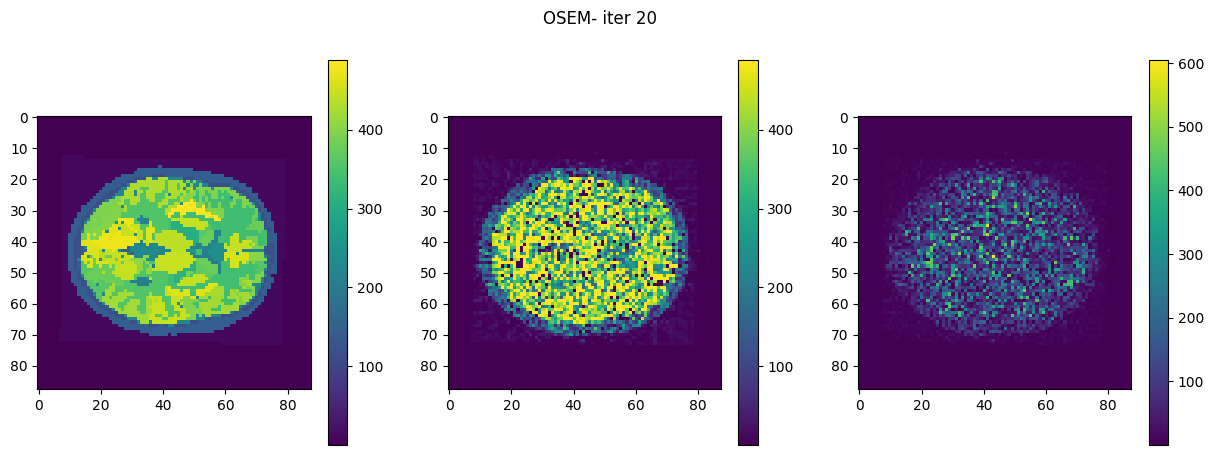

In [218]:
print(es4n2_text)
print_result(es4n2_fileprefix, es4n2_niter, "OSEM", input_img)

Experimental Setup 1 - Noise 2
Nombre original des coronnes
OSEM's RMS :  4.649562005121131


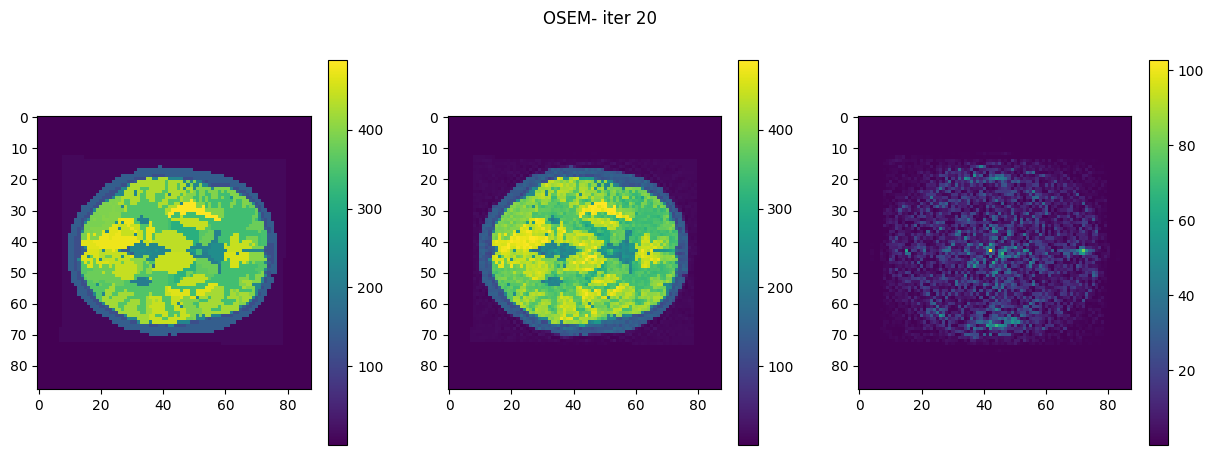

In [219]:
print(es1n2_text)
print("Nombre original des coronnes")
print_result(es1n2_fileprefix, es1n2_niter, "OSEM", input_img)

Experimental Setup 5 - Noise 2 - Plus Coronnes
OSEM's RMS :  1.9641759303068895


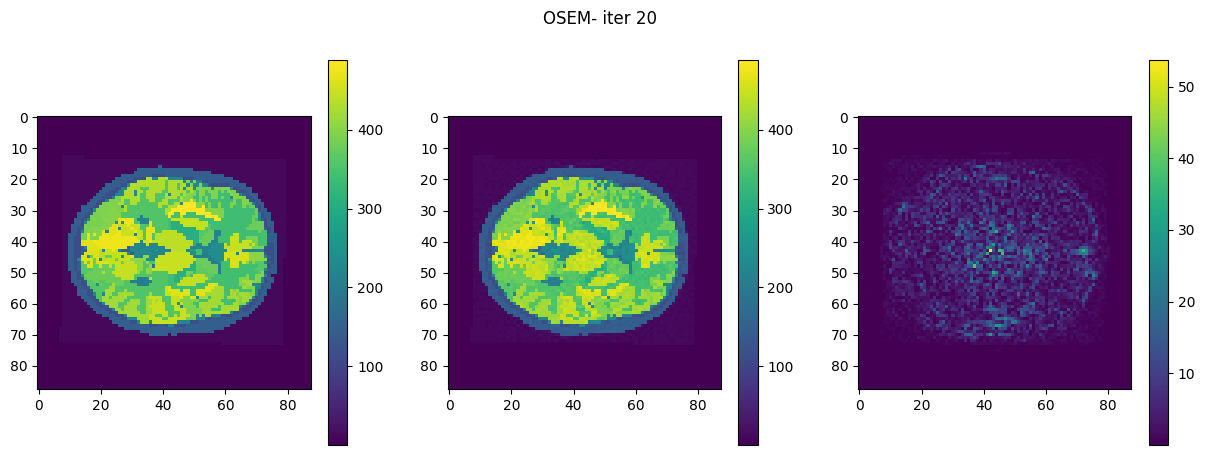

In [220]:
print(es5n2_text)
print_result(es5n2_fileprefix, es5n2_niter, "OSEM", input_img)

Au fur et à mesure que nous augmentons le nombre de `coronnes`, la reconstruction s'approche plus à l'image originale.

## Distance Radius en mm
### Setup 6 : Petit radius

In [221]:
es6 = get_experimental_setup(
    radius_mm=25, 
    detector_name="Detecteur 6 : Petit radius"
)

detector_type: DetectorType.PET
radius_mm: 25
pixel_size: [ 1  1 10]
pixels_per_slice_nb: 150
detector_slice_nb: 6
slice_pitch_mm: 35
image_matrix_size_mm: [264 264  90]
voxel_size_mm: [ 3  3 30]
h_fan_size: 50
detector_name: Detecteur 6 : Petit radius
number of projections: 272700


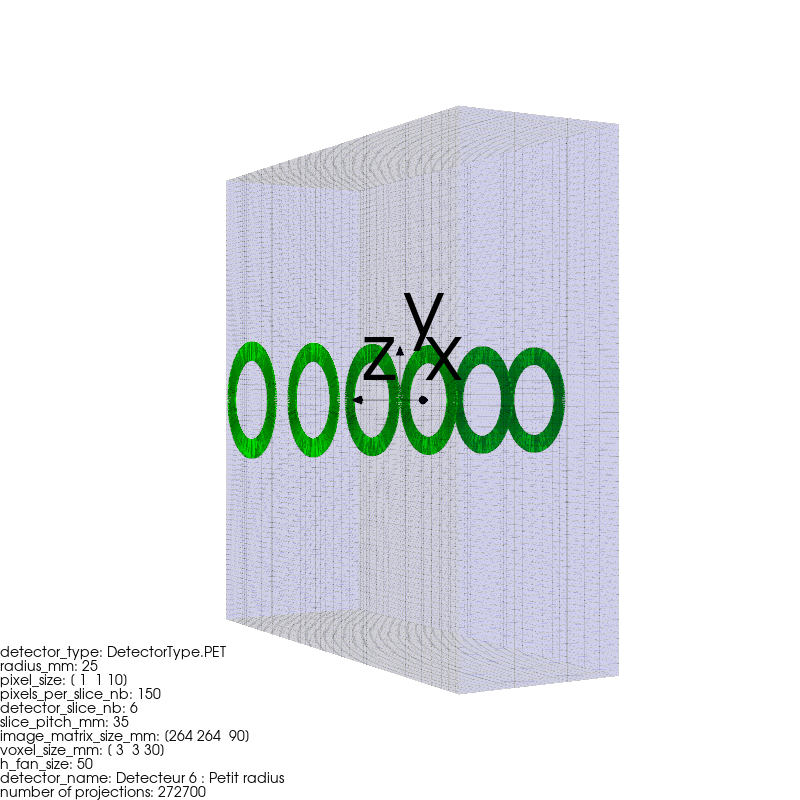

In [222]:
es6.Draw(use_jupyter=1,camera_pos_mm=(700,0,400))

In [223]:
es6n2_text="Experimental Setup 6 - Noise 2 - Petit Radius"
es6n2_name = "es6n2"
es6n2_fileprefix = get_prefix(es6n2_name, es6n2_name)
es6n2_niter = 20

es6pn2 = get_projections(input_img, es6, noise=2)

reconstruct( exp_setup=es6, projections=es6pn2, algorithm="OSEM", niter=es6n2_niter, nsubsets=20, initial_value=1, fileprefix=es6n2_fileprefix )

### Setup 7 : Grand radius

In [224]:
es7 = get_experimental_setup(
    radius_mm = 475, 
    detector_name="Detecteur 7 : Grand radius"
)

detector_type: DetectorType.PET
radius_mm: 475
pixel_size: [ 1  1 10]
pixels_per_slice_nb: 150
detector_slice_nb: 6
slice_pitch_mm: 35
image_matrix_size_mm: [264 264  90]
voxel_size_mm: [ 3  3 30]
h_fan_size: 50
detector_name: Detecteur 7 : Grand radius
number of projections: 272700


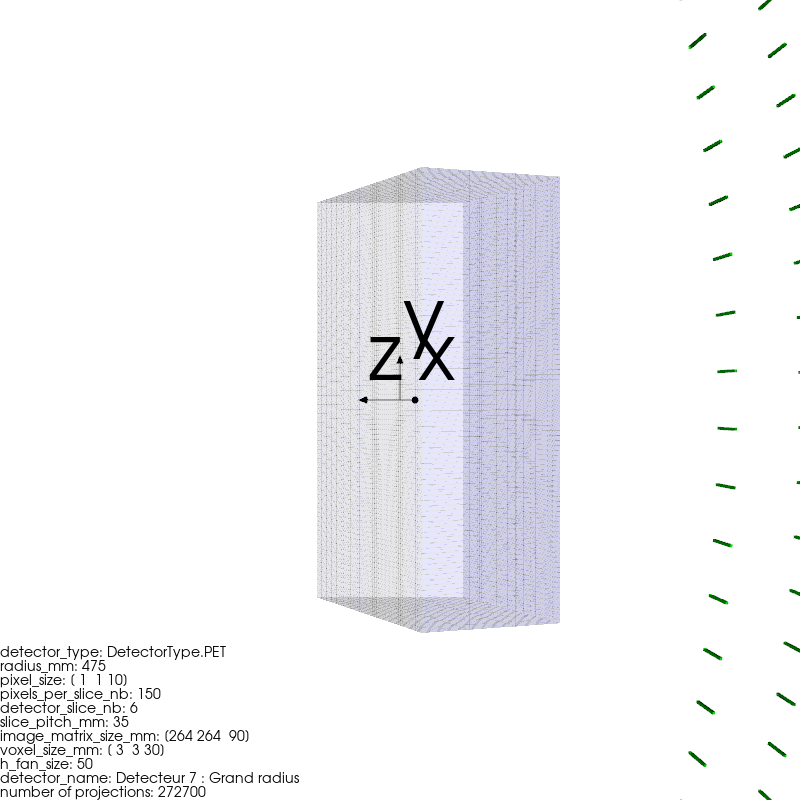

In [225]:
es7.Draw(use_jupyter=1,camera_pos_mm=(900,0,400))

In [226]:
es7n2_text="Experimental Setup 7 - Noise 2 - Grand Radius"
es7n2_name = "es7n2"
es7n2_fileprefix = get_prefix(es7n2_name, es7n2_name)
es7n2_niter = 20

es7pn2 = get_projections(input_img, es7, noise=2)

reconstruct( exp_setup=es7, projections=es7pn2, algorithm="OSEM", niter=es7n2_niter, nsubsets=20, initial_value=1, fileprefix=es7n2_fileprefix )

### Comparaison

Experimental Setup 6 - Noise 2 - Petit Radius
OSEM's RMS :  99.02681163435768


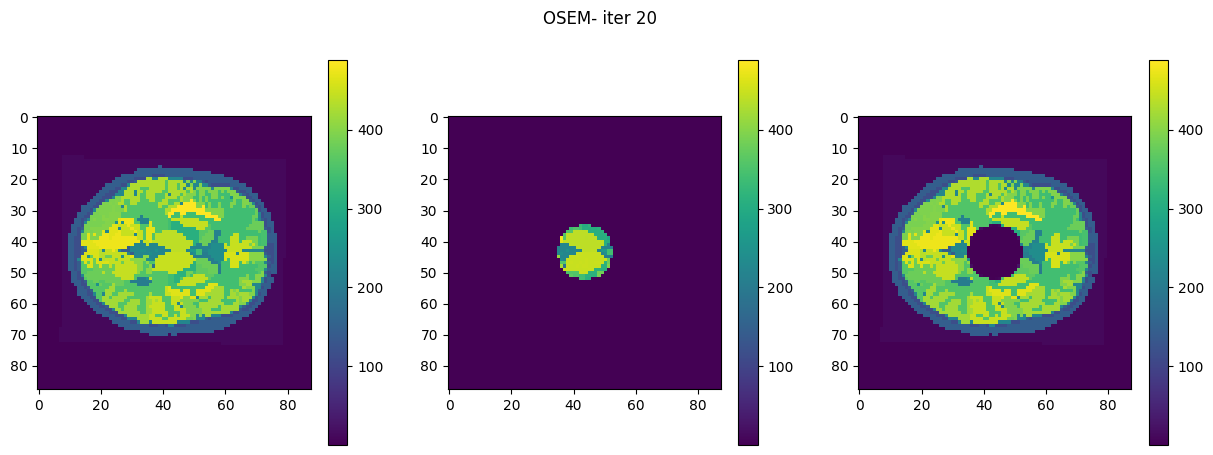

In [227]:
print(es6n2_text) 
print_result(es6n2_fileprefix, es6n2_niter, "OSEM", input_img)

Experimental Setup 1 - Noise 2
Distance original du radius
OSEM's RMS :  4.649562005121131


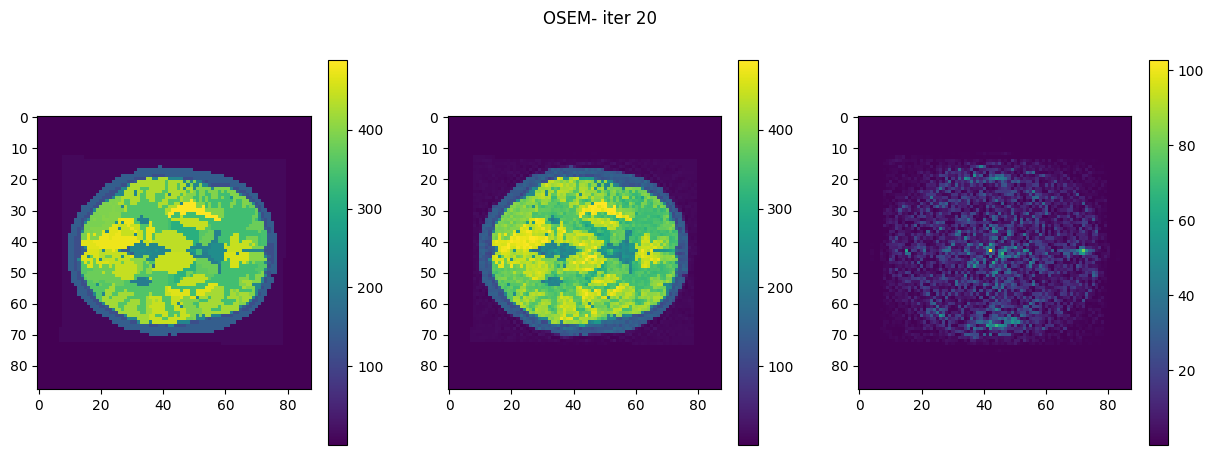

In [228]:
print(es1n2_text) 
print("Distance original du radius") 
print_result(es1n2_fileprefix, es1n2_niter, "OSEM", input_img)

Experimental Setup 7 - Noise 2 - Grand Radius
OSEM's RMS :  15.30681525297031


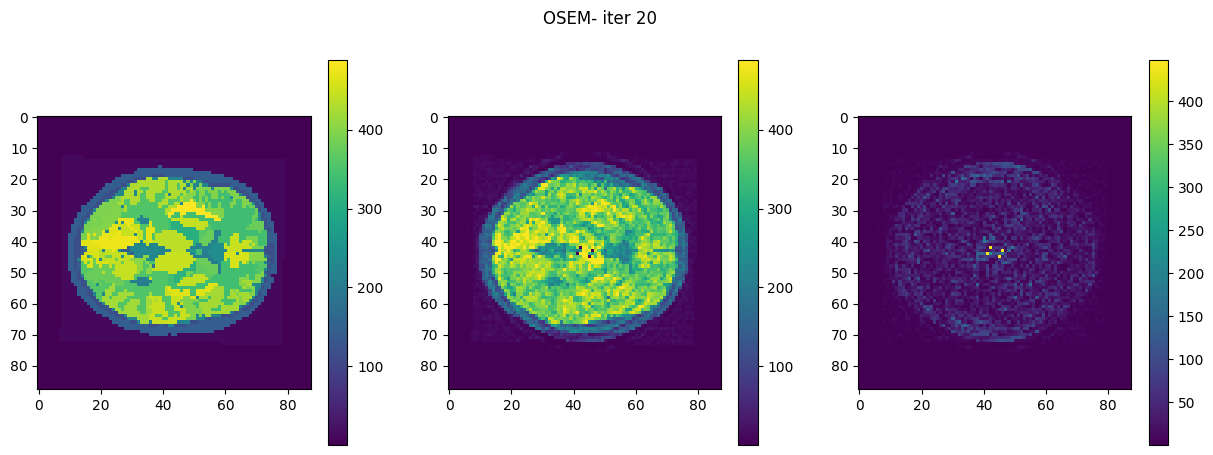

In [229]:
print(es7n2_text) 
print_result(es7n2_fileprefix, es7n2_niter, "OSEM", input_img)

Le `radio` ne doit pas être aussi petit ni aussi grand. Par contre, il faut trouver la distance optimale moyenne pour avoir une bonne reconstruction

## Nombre des pixels per slice
### Setup 8 : Moins des pixels per slice

In [230]:
es8 = get_experimental_setup(
    pixels_per_slice_nb = 101, #Les pixels per slice dois etre plus que 2*h_fan+1
    detector_name="Detecteur 8 : Moins des pixels per slice"
)

detector_type: DetectorType.PET
radius_mm: 250
pixel_size: [ 1  1 10]
pixels_per_slice_nb: 101
detector_slice_nb: 6
slice_pitch_mm: 35
image_matrix_size_mm: [264 264  90]
voxel_size_mm: [ 3  3 30]
h_fan_size: 50
detector_name: Detecteur 8 : Moins des pixels per slice
number of projections: 181800


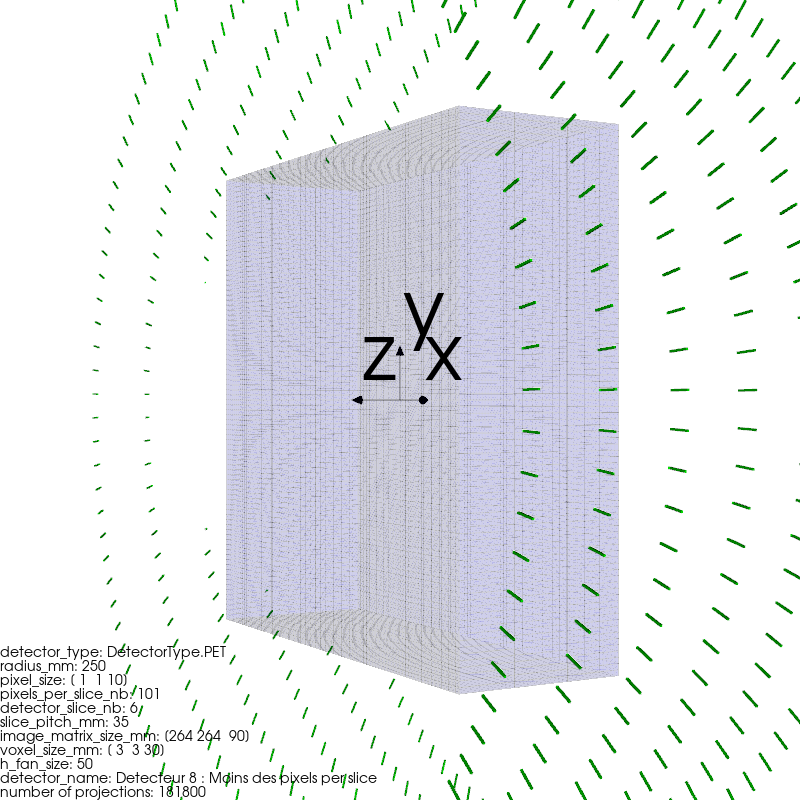

In [231]:
es8.Draw(use_jupyter=1,camera_pos_mm=(700,0,400))

In [232]:
es8n2_text="Experimental Setup 8 - Noise 2 - Moins des pixels per slice"
es8n2_name = "es8n2"
es8n2_fileprefix = get_prefix(es8n2_name, es8n2_name)
es8n2_niter = 20

es8pn2 = get_projections(input_img, es8, noise=2)

reconstruct( exp_setup=es8, projections=es8pn2, algorithm="OSEM", niter=es8n2_niter, nsubsets=20, initial_value=1, fileprefix=es8n2_fileprefix )

### Setup 9 : Plus des pixels per slice

In [233]:
es9 = get_experimental_setup(
    pixels_per_slice_nb = 285,
    detector_name="Detecteur 9 : Plus des pixels per slice"
)

detector_type: DetectorType.PET
radius_mm: 250
pixel_size: [ 1  1 10]
pixels_per_slice_nb: 285
detector_slice_nb: 6
slice_pitch_mm: 35
image_matrix_size_mm: [264 264  90]
voxel_size_mm: [ 3  3 30]
h_fan_size: 50
detector_name: Detecteur 9 : Plus des pixels per slice
number of projections: 523260


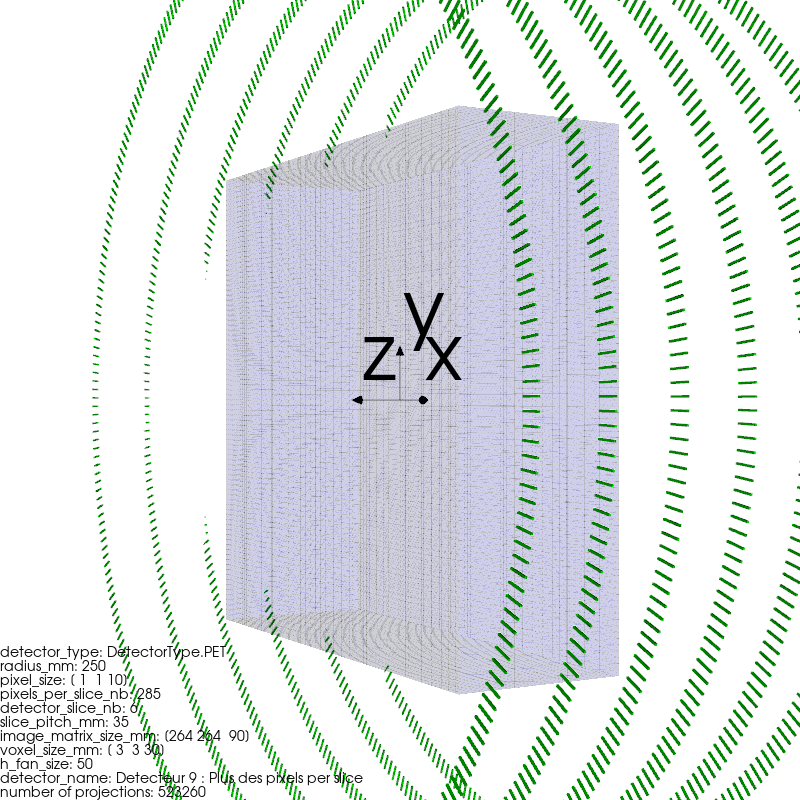

In [234]:
es9.Draw(use_jupyter=1,camera_pos_mm=(700,0,400))

In [235]:
es9n2_text="Experimental Setup 9 - Noise 2 - Plus des pixels per slice"
es9n2_name = "es9n2"
es9n2_fileprefix = get_prefix(es9n2_name, es9n2_name)
es9n2_niter = 20

es9pn2 = get_projections(input_img, es9, noise=2)

reconstruct( exp_setup=es9, projections=es9pn2, algorithm="OSEM", niter=es9n2_niter, nsubsets=20, initial_value=1, fileprefix=es9n2_fileprefix )

### Comparaison

Experimental Setup 8 - Noise 2 - Moins des pixels per slice
OSEM's RMS :  9.88905089382844


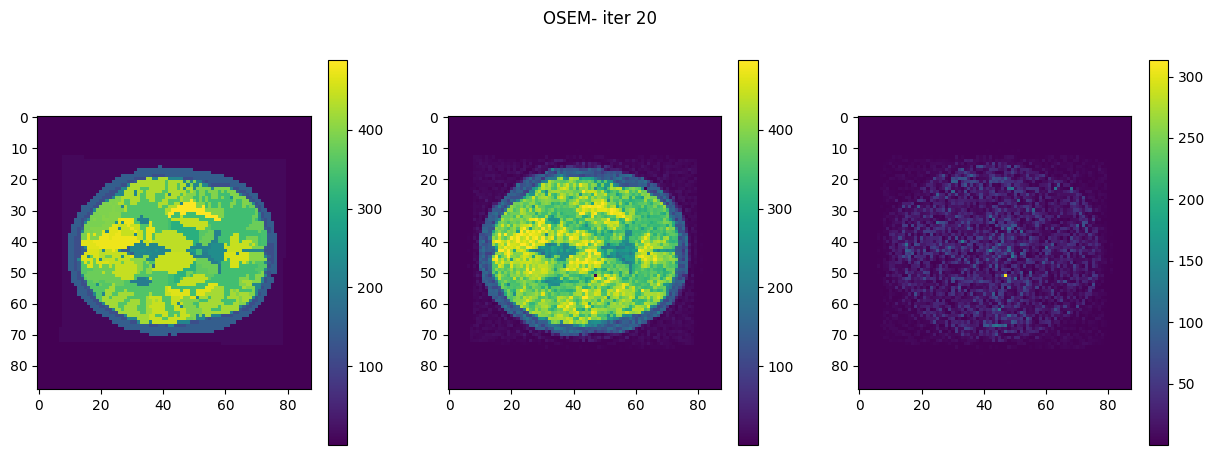

In [236]:
print(es8n2_text) 
print_result(es8n2_fileprefix, es8n2_niter, "OSEM", input_img)

Experimental Setup 1 - Noise 2
Distance original du radius
OSEM's RMS :  4.649562005121131


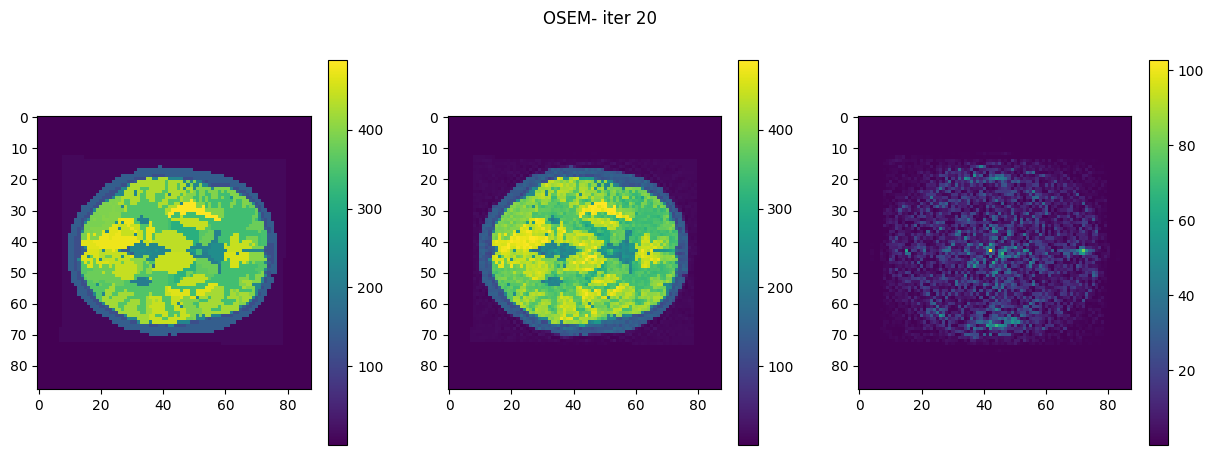

In [237]:
print(es1n2_text) 
print("Distance original du radius") 
print_result(es1n2_fileprefix, es1n2_niter, "OSEM", input_img)

Experimental Setup 9 - Noise 2 - Plus des pixels per slice
OSEM's RMS :  1.5289414534771846


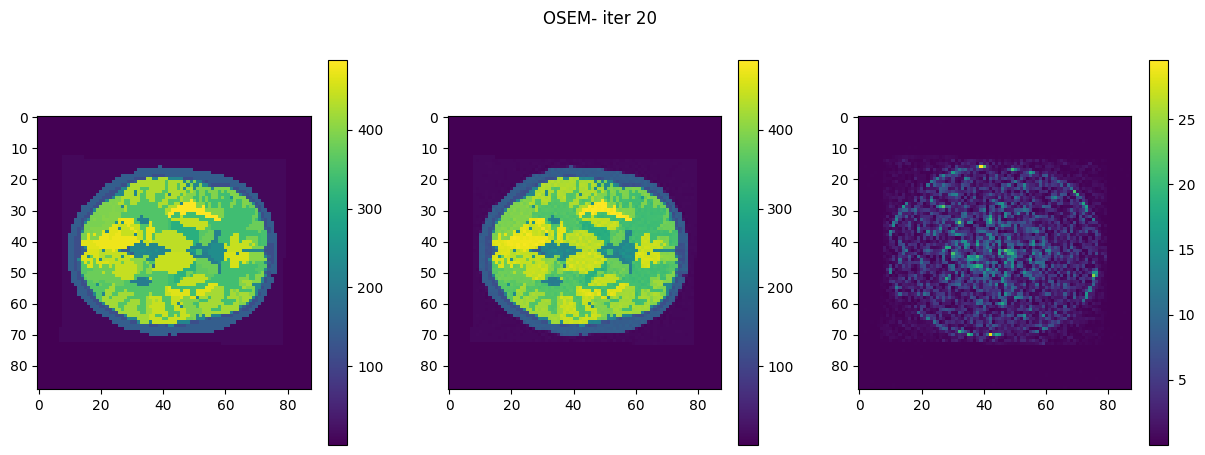

In [238]:
print(es9n2_text) 
print_result(es9n2_fileprefix, es9n2_niter, "OSEM", input_img)

Au fur et à mesure que nous augmentons le nombre de `pixels per slice`, la reconstruction s'approche plus à l'image originale.

## Nombre de détecteurs 
### Setup 10 : Moins de nombre de détecteurs 

In [239]:
es10 = get_experimental_setup(
    h_fan_size = 5,
    detector_name="Detecteur 10 : Moins de nombre de détecteurs"
)

detector_type: DetectorType.PET
radius_mm: 250
pixel_size: [ 1  1 10]
pixels_per_slice_nb: 150
detector_slice_nb: 6
slice_pitch_mm: 35
image_matrix_size_mm: [264 264  90]
voxel_size_mm: [ 3  3 30]
h_fan_size: 5
detector_name: Detecteur 10 : Moins de nombre de détecteurs
number of projections: 29700


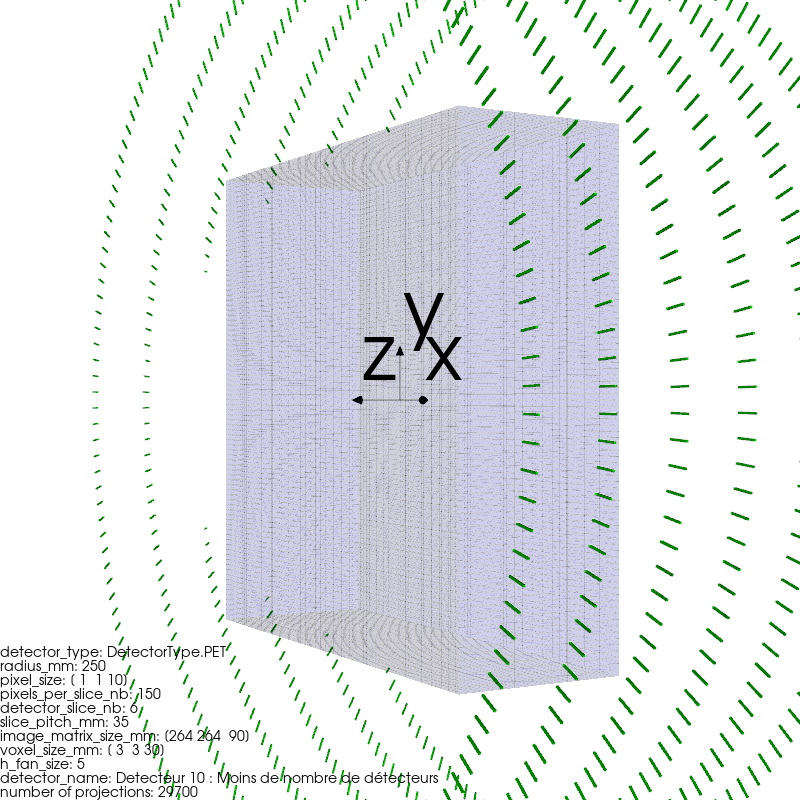

In [240]:
es10.Draw(use_jupyter=1,camera_pos_mm=(700,0,400))

In [241]:
es10n2_text="Experimental Setup 10 - Noise 2 - Moins de nombre de détecteurs"
es10n2_name = "es10n2"
es10n2_fileprefix = get_prefix(es10n2_name, es10n2_name)
es10n2_niter = 20

es10pn2 = get_projections(input_img, es10, noise=2)

reconstruct( exp_setup=es10, projections=es10pn2, algorithm="OSEM", niter=es10n2_niter, nsubsets=20, initial_value=1, fileprefix=es10n2_fileprefix )

### Setup 11 : Plus de nombre de détecteurs 

In [242]:
es11 = get_experimental_setup(
    h_fan_size = 74,  #Les pixels per slice dois etre plus que 2*h_fan+1
    detector_name="Detecteur 11 : Plus de nombre de détecteurs"
)

detector_type: DetectorType.PET
radius_mm: 250
pixel_size: [ 1  1 10]
pixels_per_slice_nb: 150
detector_slice_nb: 6
slice_pitch_mm: 35
image_matrix_size_mm: [264 264  90]
voxel_size_mm: [ 3  3 30]
h_fan_size: 74
detector_name: Detecteur 11 : Plus de nombre de détecteurs
number of projections: 402300


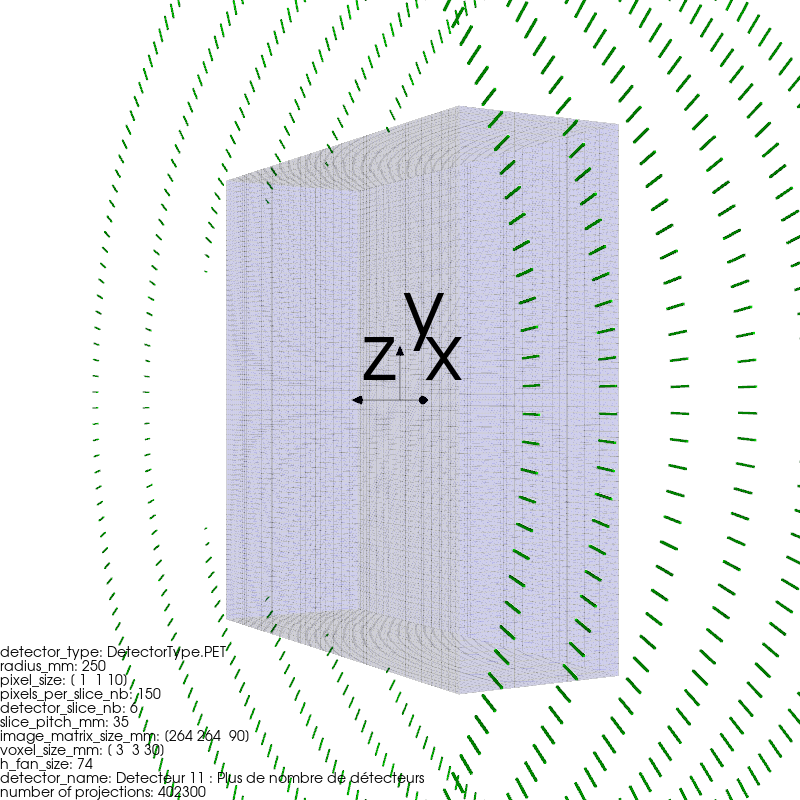

In [243]:
es11.Draw(use_jupyter=1,camera_pos_mm=(700,0,400))

In [244]:
es11n2_text="Experimental Setup 11 - Noise 2 - Plus de nombre de détecteurs"
es11n2_name = "es11n2"
es11n2_fileprefix = get_prefix(es11n2_name, es11n2_name)
es11n2_niter = 20

es11pn2 = get_projections(input_img, es11, noise=2)

reconstruct( exp_setup=es11, projections=es11pn2, algorithm="OSEM", niter=es11n2_niter, nsubsets=20, initial_value=1, fileprefix=es11n2_fileprefix )

### Comparaison

Experimental Setup 10 - Noise 2 - Moins de nombre de détecteurs
OSEM's RMS :  55.993129684705


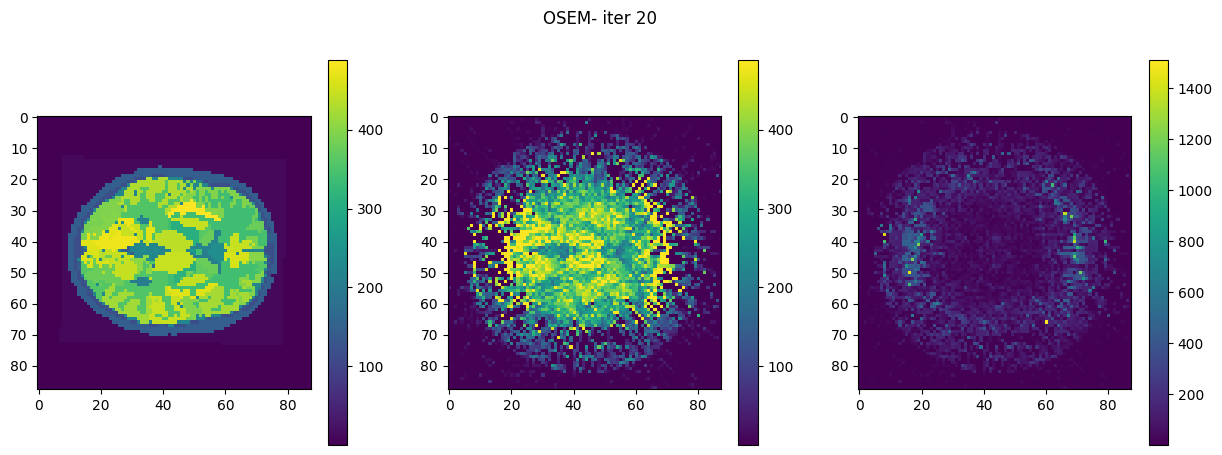

In [245]:
print(es10n2_text) 
print_result(es10n2_fileprefix, es10n2_niter, "OSEM", input_img)

Experimental Setup 1 - Noise 2
Distance original du radius
OSEM's RMS :  4.649562005121131


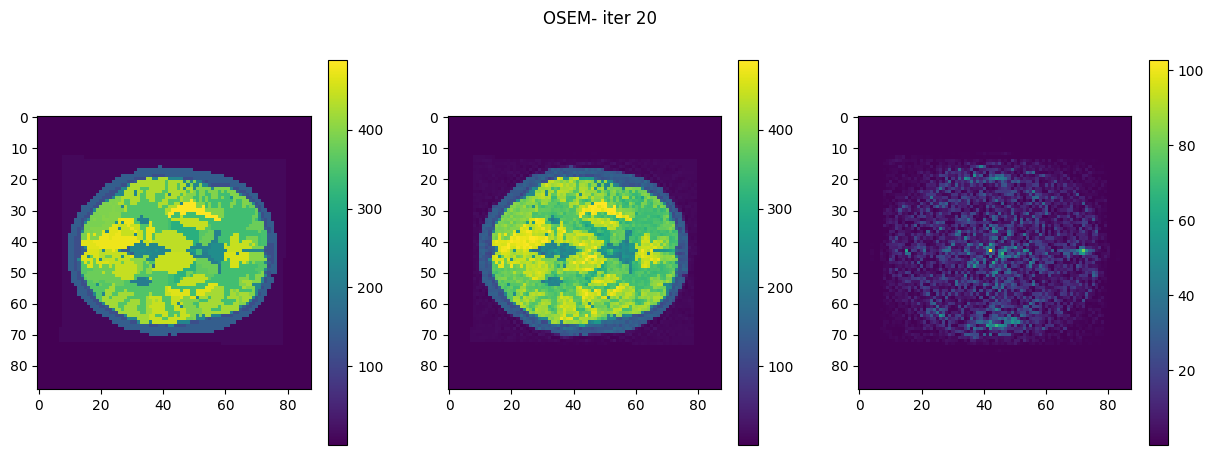

In [246]:
print(es1n2_text) 
print("Distance original du radius") 
print_result(es1n2_fileprefix, es1n2_niter, "OSEM", input_img)

Experimental Setup 11 - Noise 2 - Plus de nombre de détecteurs
OSEM's RMS :  4.6363549745221775


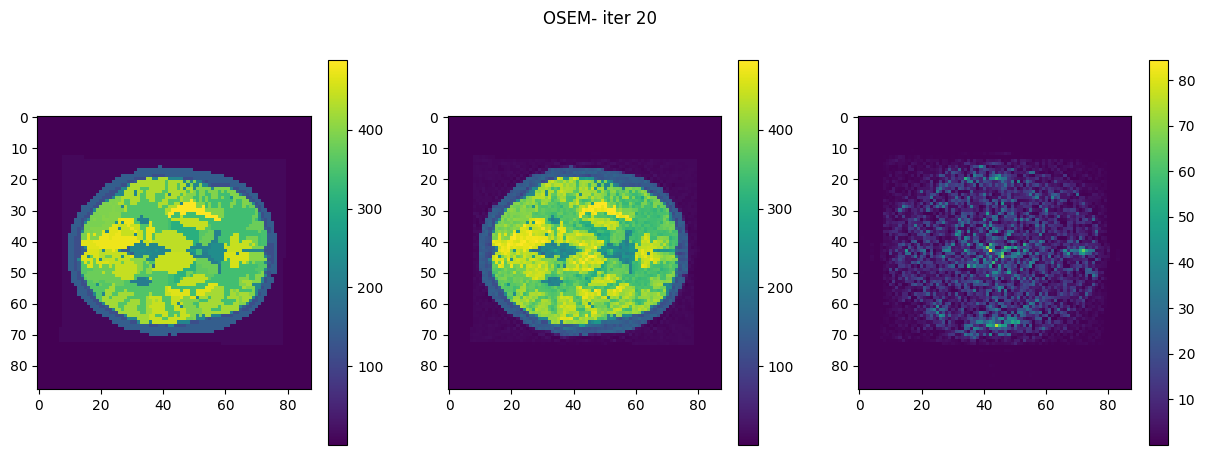

In [247]:
print(es11n2_text) 
print_result(es11n2_fileprefix, es11n2_niter, "OSEM", input_img)

Augmenter le nombre de detecteurs par dans le `h_fan` ne garanti pas avoir un meilleur résultat. Par contre, si nous reduissons beaucoup ce valeur, l'image résulante deviennent plus bruitée.